In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os
import warnings

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [2]:
# Helper functions
# https://libguides.usc.edu/busdem/age
def gen_label(age):
    if age <= 10.0:
        return 'Gen Alpha'
    elif 10.0 < age <= 29.0:
        return 'Gen Z'
    elif 29.0 < age <= 44.0:
        return 'Millenial'
    elif 44.0 < age <= 59.0:
        return 'Gen X'
    elif 59.0 < age <= 74.0:
        return 'Baby Boomers'
    elif 74.0 < age <= 89.0:
        return 'Silent Gen'
    elif 89.0 < age <= 104.0:
        return 'Greatest Gen'

def get_customer_segment(original_df, r_range, f_range, m_range):
    res = pd.DataFrame()
    for r in r_range:
        for f in r_range:
            for m in m_range:
                res = pd.concat([res, original_df[original_df['RFM_Segment'] == (r + f + m)]], axis=0)
    return res

# https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif col != 't_dat':
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

# Step 1: Exploratory Data Analysis (EDA)

In [3]:
input_path_prefix = "/kaggle/input/h-and-m-personalized-fashion-recommendations/"

print('-' * 80)
print('articles')
pre_articles = import_data(input_path_prefix + "articles.csv")
#pre_articles = pd.read_csv('Data/articles.csv')
print('-' * 80)
print('customers\'s memory usage will be better off without the memory optimization')
pre_customers = pd.read_csv(input_path_prefix + "customers.csv")
#pre_customers = pd.read_csv('Data/customers.csv')
print('-' * 80)
print('transactions')
pre_transactions = import_data(input_path_prefix + "transactions_train.csv")
#pre_transactions = pd.read_csv('Data/transactions_train.csv')

--------------------------------------------------------------------------------
articles
Memory usage of dataframe is 20.13 MB
Memory usage after optimization is: 7.25 MB
Decreased by 64.0%
--------------------------------------------------------------------------------
customers's memory usage will be better off without the memory optimization
--------------------------------------------------------------------------------
transactions
Memory usage of dataframe is 1212.63 MB
Memory usage after optimization is: 618.64 MB
Decreased by 49.0%


## Step 1.1: EDA - Customers

Customers data description:

* customer_id : A unique identifier of every customer
* FN : 1 or missed
* Active : 1 or missed
* club_member_status : Status in club
* fashion_news_frequency : How often H&M may send news to customer
* age : The current age
* postal_code : Postal code of customer

EDA Steps:

1. Duplicate Customers: check for duplicate customer ids
2. Abnormal Postal Code: abnormal number of customers by one postal code
3. Common age: average age of all customers
4. H&M club status: distribution of customers' club status
5. No Data: unite three types of No Data
6. Customer Preference: see if customers are interested in messages about current news

**There are no duplicates in customers.**

In [4]:
pre_customers.shape[0] - pre_customers['customer_id'].nunique()

0

**Here we have abnormal number of customers by one postal code. One has 120303, it might be encoded nan adress or smth like a huge distribution center, or pickup.**

In [5]:
pre_customers.groupby('postal_code', as_index=False).count().sort_values('customer_id', ascending=False).head()

,postal_code,customer_id,FN,Active,club_member_status,fashion_news_frequency,age
61034,2c29ae653a9282cce4151bd87643c907644e09541abc28...,120303,42874,39886,118281,114377,118002
281937,cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac...,261,109,104,261,261,260
156090,714976379549eb90aae4a71bca6c7402cc646ae7c40f6c...,159,90,88,159,159,158
171208,7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5...,157,55,54,157,156,156
126228,5b7eb31eabebd3277de632b82267286d847fd5d44287ee...,156,42,41,156,156,155


**Ages, club_member_status are different, like customer_ids.**

In [6]:
pre_customers[pre_customers['postal_code']=='2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c'].head(5)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
11,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,NaN,NaN,ACTIVE,NONE,31.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
14,0000ae1bbb25e04bdc7e35f718e852adfb3fbb72ef38b3...,1.0,1.0,ACTIVE,Regularly,29.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...


**The most common age is about 21-23.**

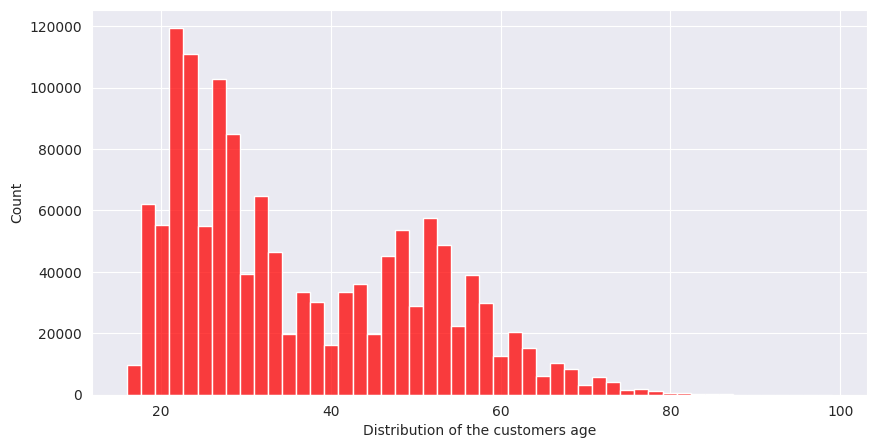

In [7]:
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=pre_customers, x='age', bins=50, color='red')
ax.set_xlabel('Distribution of the customers age')
plt.show()

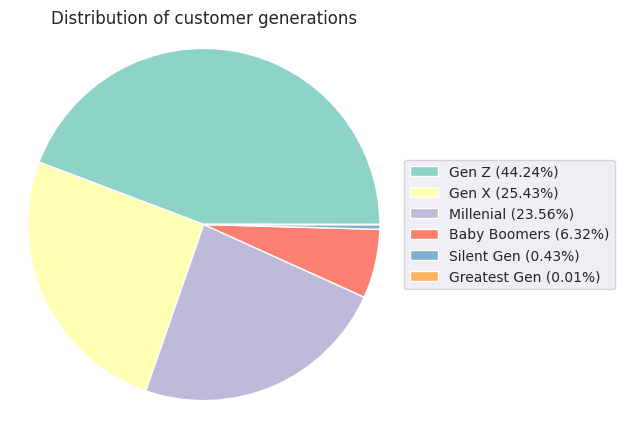

In [8]:
# Add gen label (age_group)
pre_customers['age_group'] = pre_customers['age'].apply(gen_label)
pre_customers_gen_counts = pre_customers['age_group'].value_counts()
gen_counts_dict = dict(pre_customers_gen_counts)

plt.figure(figsize=(5,5))
plt.pie(pre_customers_gen_counts, colors=sns.color_palette('Set3'))
plt.title('Distribution of customer generations')
plt.axis('equal')

percentages = [f'{gen_counts_dict[key]/sum(gen_counts_dict.values())*100:.2f}%' for key in gen_counts_dict.keys()]

plt.legend(labels=[f'{label} ({percent})' for label, percent in zip(gen_counts_dict.keys(), percentages)], loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

**Status in H&M club. Almost every customer has an active club status, some of them begin to activate it (pre-create). A tiny part of customers abandoned the club.**

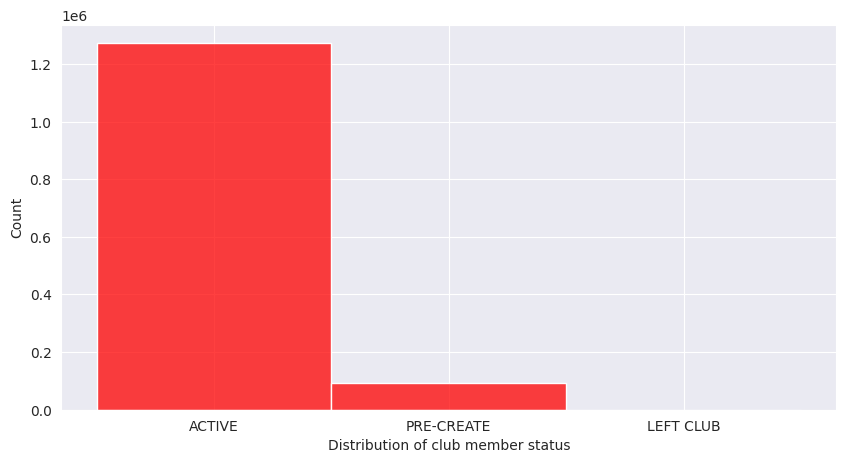

In [9]:
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=pre_customers, x='club_member_status', color='red')
ax.set_xlabel('Distribution of club member status')
plt.show()

**Here we have three types for NO DATA. We'll unite these values.**


In [10]:
pre_customers['fashion_news_frequency'].unique()

array(['NONE', 'Regularly', nan, 'Monthly'], dtype=object)

In [11]:
pre_customers.loc[~pre_customers['fashion_news_frequency'].isin(['Regularly', 'Monthly']), 'fashion_news_frequency'] = 'None'
pre_customers['fashion_news_frequency'].unique()

array(['None', 'Regularly', 'Monthly'], dtype=object)

In [12]:
pie_data = pre_customers[['customer_id', 'fashion_news_frequency']].groupby('fashion_news_frequency').count()

**Customers prefer not to get any messages about the current news.**

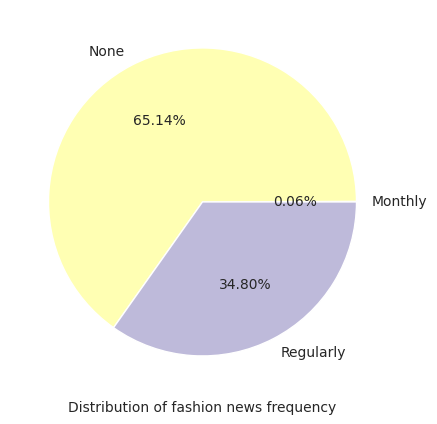

In [13]:
f, ax = plt.subplots(figsize=(10,5))
ax.pie(pie_data.customer_id, labels=pie_data.index, autopct='%1.2f%%', colors = sns.color_palette('Set3'))
ax.set_xlabel('Distribution of fashion news frequency')
plt.show()

## Step 1.2: EDA - Articles

Article data description:

* article_id : A unique identifier of every article.
* product_code, prod_name : A unique identifier of every product and its name (not the same).
* product_type, product_type_name : The group of product_code and its name
* graphical_appearance_no, graphical_appearance_name : The group of graphics and its name
* colour_group_code, colour_group_name : The group of color and its name
* perceived_colour_value_id, perceived_colour_value_name, perceived_colour_master_id, perceived_colour_master_name : The added color info
* department_no, department_name: : A unique identifier of every dep and its name
* index_code, index_name: : A unique identifier of every index and its name
* index_group_no, index_group_name: : A group of indeces and its name
* section_no, section_name: : A unique identifier of every section and its name
* garment_group_no, garment_group_name: : A unique identifier of every garment and its name
* detail_desc: : Details

EDA Steps:

1. Unique Vaues: count the number of each field.
1. Index Group Distribution: find the distrbution of index group
1. Garment Counts Grouped by Index Group: count the number of each garment and check their composition
1. Distribution of Product Groups: check the distribution of product groups
1. Product Type Counts per Group: count the number of product type within each product group

In [14]:
articles = pre_articles.copy()

**Unique Values**

In [15]:
unique_values = articles.nunique()
print(unique_values)

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64


**Distribution of Index Group**

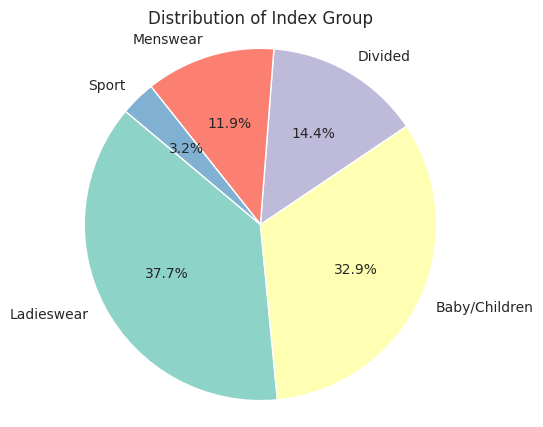

In [16]:
index_group_counts = articles['index_group_name'].value_counts()

plt.figure(figsize=(5, 5)) 
plt.pie(index_group_counts, labels = index_group_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
plt.axis('equal')
plt.title('Distribution of Index Group')

plt.show()

Ladieswear and Baby/Children are the most common index group.

**Garment Counts Grouped by Index Group**

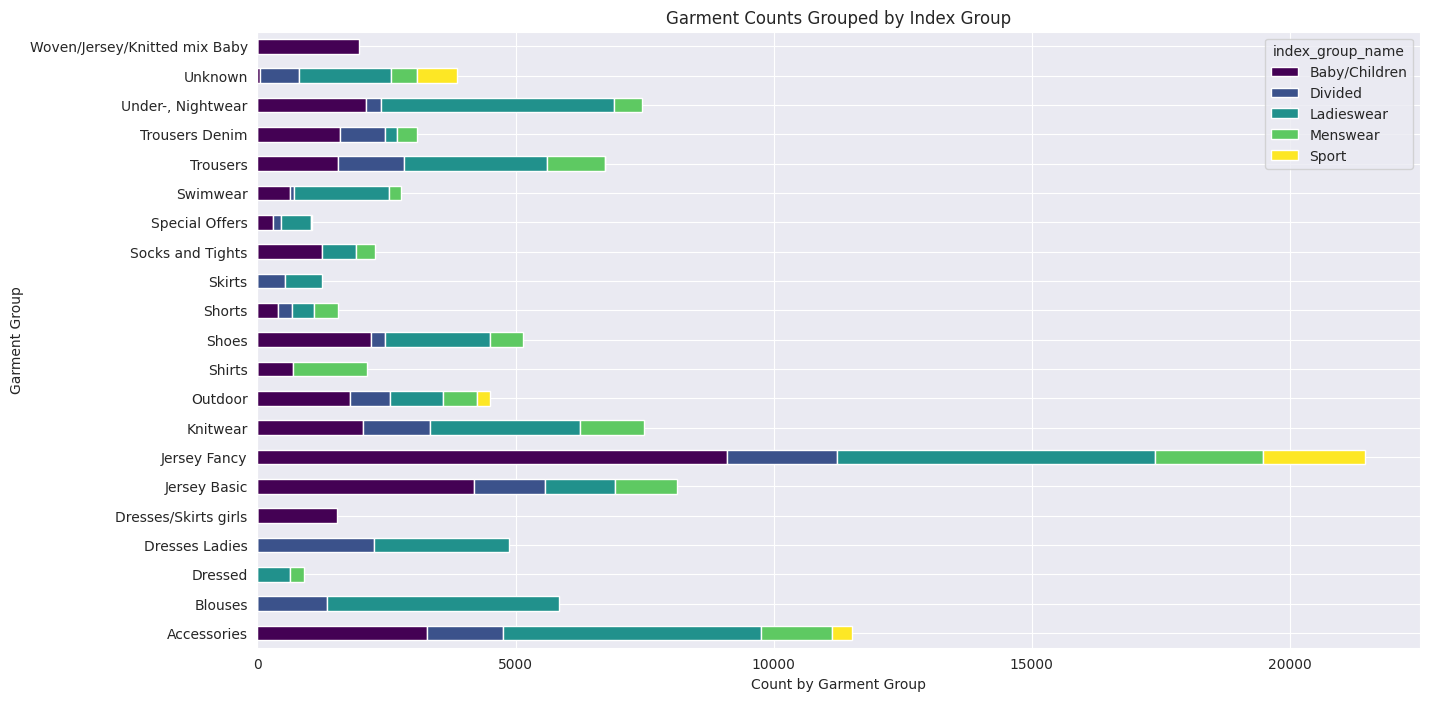

In [17]:
pivot_df = articles.pivot_table(index='garment_group_name', columns='index_group_name', aggfunc='size', fill_value=0)

pivot_df.plot(kind='barh', stacked=True, figsize=(15, 8), colormap='viridis')

plt.xlabel('Count by Garment Group')
plt.ylabel('Garment Group')
plt.title('Garment Counts Grouped by Index Group')
plt.show()

Jersey Fancy is the most common garment group, of which Ladieswear and Baby/Children account for the largest proportion.

**Distribution of Product Groups**

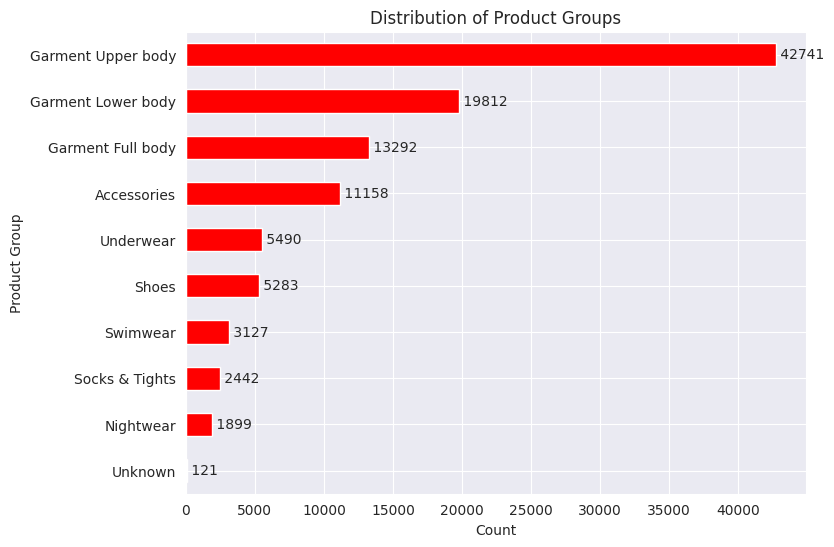

In [18]:
product_group_counts = articles['product_group_name'].value_counts().sort_values().tail(10)

# Plot the results as a bar chart
plt.figure(figsize=(8, 6)) 
bars = product_group_counts.plot(kind='barh', color='red')
plt.xlabel('Count')
plt.ylabel('Product Group')
plt.title('Distribution of Product Groups')

for bar in bars.patches:
    plt.text(
        bar.get_width(),      
        bar.get_y() + bar.get_height() / 2,  
        f' {int(bar.get_width())}', 
        va='center'  
    )

plt.show()

**Product Type Counts per Group**

In [19]:
product_type_counts_per_group = articles.groupby('product_group_name')['product_type_name'].nunique().sort_values(ascending=False)

print(product_type_counts_per_group)

product_group_name
Accessories              38
Shoes                    16
Garment Upper body       15
Underwear                11
Swimwear                  6
Garment Full body         6
Garment and Shoe care     6
Bags                      6
Garment Lower body        5
Items                     5
Nightwear                 4
Socks & Tights            3
Interior textile          3
Cosmetic                  2
Underwear/nightwear       2
Furniture                 1
Stationery                1
Fun                       1
Unknown                   1
Name: product_type_name, dtype: int64


## Step 1.3: EDA - Transactions
Transactions field description:

* t_dat : Purchase date
* day_of_week: Purchase day of week (Monday: 1, Tue: 2, …, Sun: 7) (This is a new field we added on top of the orignal dataset)
* customer_id : A unique identifier of every customer (in customers table)
* article_id : A unique identifier of every article (in articles table)
* price : Purchase price
* sales_channel_id : 1 or 2 (1 is store and 2 is online, ref: https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/305952#1684481) => It is transformed into sales_channel field with 1 is In-store and 2 is Online

EDA Steps:
1. Descriptive Statistics: Use describe() to get a statistical summary of the data.
1. Missing Values: Check for missing values using isnull().
1. Unique Values: Check the number of unique customers, articles, and sales channels.
1. Sales Distribution: Check the distribution of sales across different days of the week and sales channels.
1. Price Distribution: Analyze the distribution of the purchase price.
1. Transaction Trend: Plot the number of transactions over time (t_dat).
1. Outliers: Check for outliers in the price column.

**Descriptive Statistics - The transactions ranges from year 2018 to 2020.**

In [20]:
# Price scaling - ref: https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/310496
# https://docs.python.org/3/library/fractions.html#fractions.Fraction.limit_denominator
pre_transactions['price'] = pre_transactions['price'] * 590

In [21]:
# Add day of the week field
pre_transactions['t_dat'] = pd.to_datetime(pre_transactions['t_dat'])  # Make sure the date column is in datetime format
pre_transactions['day_of_week'] = pre_transactions['t_dat'].dt.day_name()  # Add the day of the week column
pre_transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,day_of_week
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,29.996948,2,Thursday
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,17.987366,2,Thursday
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,8.989182,2,Thursday
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,9.992981,2,Thursday
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,9.992981,2,Thursday


In [22]:
pre_transactions.describe()

,t_dat,article_id,price,sales_channel_id
count,31788324,3.178832e+07,3.178832e+07,3.178832e+07
mean,2019-09-15 17:27:46.894452992,6.962272e+08,1.641977e+01,1.704028e+00
min,2018-09-20 00:00:00,1.087750e+08,9.987354e-03,1.000000e+00
25%,2019-03-28 00:00:00,6.328030e+08,9.326782e+00,1.000000e+00
50%,2019-08-25 00:00:00,7.145820e+08,1.498947e+01,2.000000e+00
75%,2020-03-29 00:00:00,7.865240e+08,1.998596e+01,2.000000e+00
max,2020-09-22 00:00:00,9.562170e+08,3.488721e+02,2.000000e+00
std,NaN,1.334480e+08,1.131768e+01,4.564786e-01


**Missing Values - There is no missing value in the transactions.**

In [23]:
print(pre_transactions.isnull().sum())

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
day_of_week         0
dtype: int64


**Unique Values - The number of unique customers is over 1.3M.**

In [24]:
print("Unique Customers: ", pre_transactions['customer_id'].nunique())
print("Unique Articles: ", pre_transactions['article_id'].nunique())
print("Unique Sales Channels: ", pre_transactions['sales_channel_id'].nunique())

Unique Customers:  1362281
Unique Articles:  104547
Unique Sales Channels:  2


**Sales Distribution - The day of week distribution is roughly even but people shop the most on Saturdays. And the sales channel is dominated by Online channel.**

In [25]:
sales_channel_mapping = {1: 'In-store', 2: 'Online'}
pre_transactions['sales_channel_id'] = pre_transactions['sales_channel_id'].map(sales_channel_mapping)

In [26]:
pre_transactions = pre_transactions.rename(columns={'sales_channel_id': 'sales_channel'})

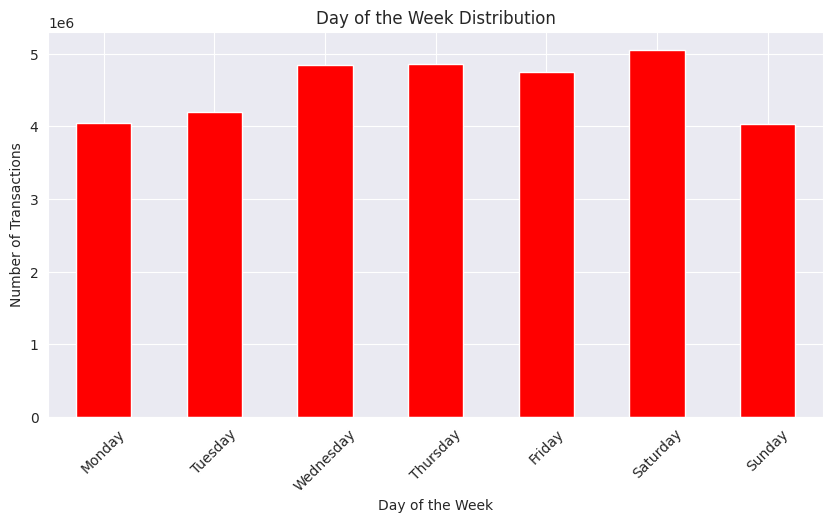

In [27]:
# Define the desired order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
day_of_week_pre_transactions = pd.Categorical(pre_transactions['day_of_week'], categories=day_order, ordered=True)
day_of_week_pre_transactions.value_counts().sort_index().plot(kind='bar', color='red')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.title('Day of the Week Distribution')
plt.xticks(rotation=45)
plt.show()

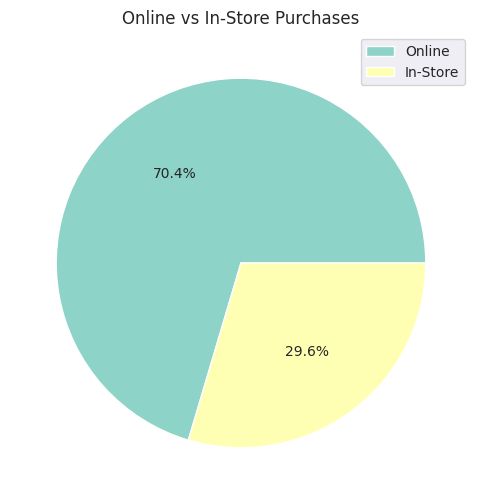

In [28]:
plt.figure(figsize=(6, 6))
plt.pie(pre_transactions['sales_channel'].value_counts(), autopct='%1.1f%%', colors=sns.color_palette('Set3'))
plt.title('Online vs In-Store Purchases')
plt.legend(['Online', 'In-Store'], loc='upper right') # Add this line to include the legend
plt.show()

In [29]:
pre_transactions.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel',
       'day_of_week'],
      dtype='object')

**Price distribution - Over 98.8% purchase price is below €50.**

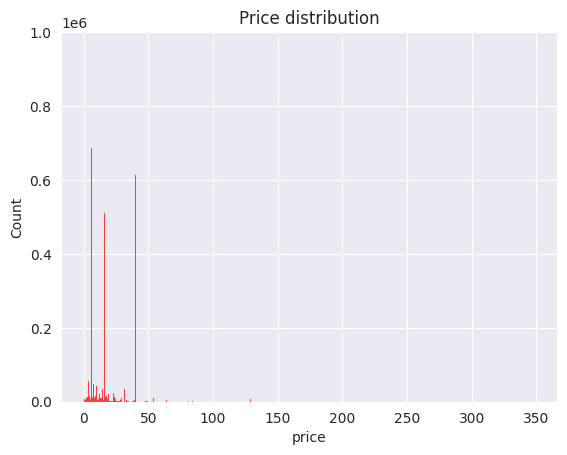

In [30]:
sns.histplot(pre_transactions['price'], color='red')
plt.ylim(0, 1000000)
plt.title("Price distribution")
plt.show()

In [31]:
pre_transactions[pre_transactions['price'] < 50].count().iloc[0] / pre_transactions.count().iloc[0]

0.9883719569487212

**Transaction Trend - Transactions tend to peak around June (Summer) every year.**

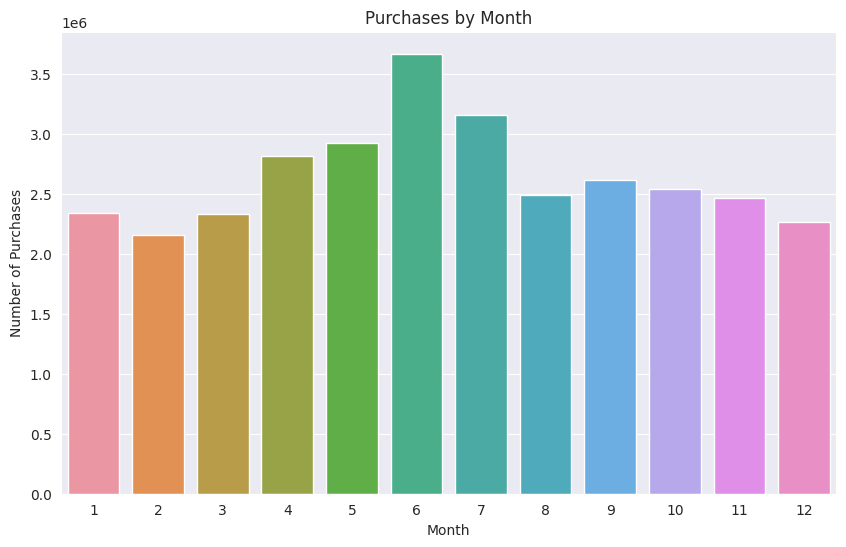

In [32]:
pre_transactions['t_dat'] = pd.to_datetime(pre_transactions['t_dat'])
seasonality_pre_transactions = pre_transactions['t_dat'].apply(lambda x: x.month).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=seasonality_pre_transactions.index, y=seasonality_pre_transactions.values)
plt.title('Purchases by Month')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.show()

**Outliers (in price) - IQR price range (€0~20) looks normal and it shows that most people buy items less than €20 from H&M**

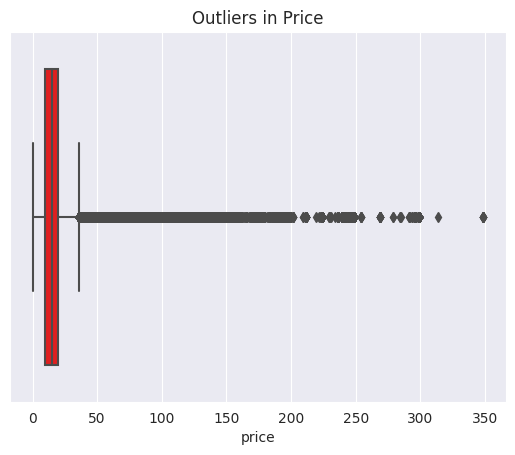

In [33]:
sns.boxplot(x=pre_transactions['price'], color='red')
plt.title("Outliers in Price")
plt.show()

# Step 2: Data preprocessing

In [34]:
customer_ids = pre_customers['customer_id'].unique()
customer_id_number = {customer_id: i+1 for i, customer_id in enumerate(customer_ids)}
customers = pre_customers.copy()
customers['customer_id'] = customers['customer_id'].map(customer_id_number)
transactions = pre_transactions.copy()
transactions['customer_id'] = transactions['customer_id'].map(customer_id_number)

In [35]:
transactions = pd.merge(transactions, customers[['customer_id', 'age', 'age_group']], on='customer_id', how='left')

In [36]:
transactions = pd.merge(transactions, articles[['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc']], on='article_id', how='left')

In [37]:
transactions = transactions.dropna(subset=['age'])

In [38]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel,day_of_week,age,age_group,product_code,prod_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,3,663713001,29.996948,Online,Thursday,24.0,Gen Z,663713,Atlanta Push Body Harlow,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
1,2018-09-20,3,541518023,17.987366,Online,Thursday,24.0,Gen Z,541518,Rae Push (Melbourne) 2p,...,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up bras with underwired, moulded, pa..."
2,2018-09-20,8,505221004,8.989182,Online,Thursday,32.0,Millenial,505221,Inca Jumper,...,Tops Knitwear DS,D,Divided,2,Divided,58,Divided Selected,1003,Knitwear,Jumper in rib-knit cotton with hard-worn detai...
3,2018-09-20,8,685687003,9.992981,Online,Thursday,32.0,Millenial,685687,W YODA KNIT OL OFFER,...,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...
4,2018-09-20,8,685687004,9.992981,Online,Thursday,32.0,Millenial,685687,W YODA KNIT OL OFFER,...,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...


In [39]:
transactions.shape

(31648066, 32)

In [40]:
# Release unused memory
del articles, customers, pre_customers, pre_articles, pre_transactions

# Step 3: RFM Analysis
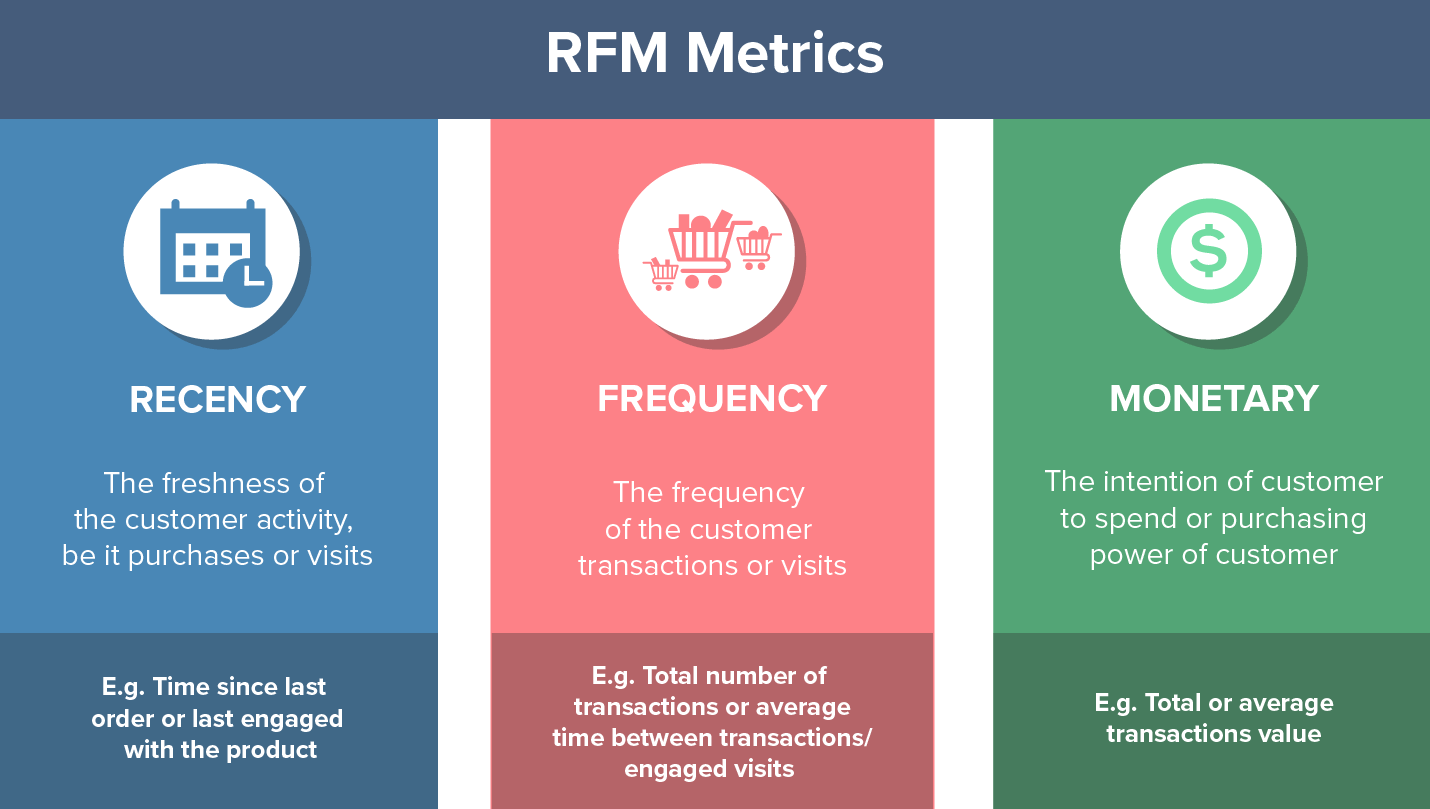

## Step 3.1: Run RFM Analysis and get R, F, and M scores (which could be 1, 2, 3, 4, or 5) for each customer

In [41]:
snapshot_date = transactions['t_dat'].max() + pd.Timedelta(days=1) # day after the last transaction date
recency_data = transactions.groupby('customer_id')['t_dat'].agg(recency=lambda x: (snapshot_date - x.max()).days)
frequency_data = transactions.groupby('customer_id')['t_dat'].nunique()
monetary_data = transactions.groupby('customer_id')['price'].sum()

rfm_df = pd.concat([recency_data, frequency_data, monetary_data], axis=1)
rfm_df.reset_index(inplace=True)
rfm_df.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

rfm_seg = pd.qcut(rfm_df['Recency'], q=5, labels=['5', '4', '3', '2', '1'])
rfm_df['R'] = rfm_seg.astype(str)

rfm_seg = pd.qcut(rfm_df['Frequency'], q=5, labels=['1', '2', '3', '4'], duplicates='drop')
rfm_df['F'] = rfm_seg.astype(str)

rfm_seg = pd.qcut(rfm_df['Monetary'], q=5, labels=['1', '2', '3', '4', '5'])
rfm_df['M'] = rfm_seg.astype(str)

rfm_df['RFM_Segment'] = rfm_df['R'] + rfm_df['F'] + rfm_df['M']

rfm_df['RFM_Score'] = rfm_df['R'].astype(int) + rfm_df['F'].astype(int) + rfm_df['M'].astype(int)

rfm_df.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,1,18,10,382.924744,5,3,4,534,12
1,2,77,23,1535.315796,4,4,5,445,13
2,3,8,7,415.856567,5,3,4,534,12
3,4,472,1,35.974731,1,1,1,111,3
4,5,42,6,277.111664,4,3,4,434,11


In [42]:
# Release unused memory
del snapshot_date, recency_data, frequency_data, monetary_data

## Step 3.2: Observe the R, F, and M score distributions 

In [43]:
rfm_df['R'].value_counts()

R
5    271826
3    269362
2    269036
1    268320
4    267976
Name: count, dtype: int64

In [44]:
rfm_df['F'].value_counts()

F
1    619886
3    267392
4    264194
2    195048
Name: count, dtype: int64

In [45]:
rfm_df['M'].value_counts()

M
1    269333
5    269304
4    269301
3    269301
2    269281
Name: count, dtype: int64

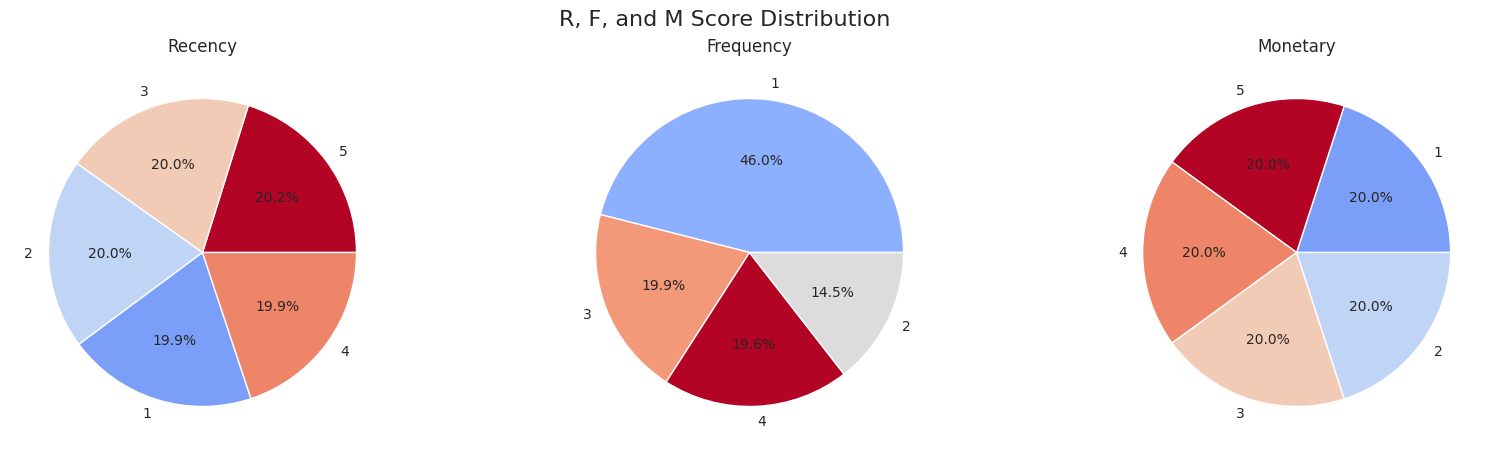

In [46]:
# Aggregate the data
r_counts = rfm_df['R'].value_counts()
f_counts = rfm_df['F'].value_counts()
m_counts = rfm_df['M'].value_counts()

# Create a colormap
cmap = plt.get_cmap('coolwarm')

# Convert index to numeric type and normalize
r_colors = cmap(pd.to_numeric(r_counts.index) / pd.to_numeric(r_counts.index).max())
f_colors = cmap(pd.to_numeric(f_counts.index) / pd.to_numeric(f_counts.index).max())
m_colors = cmap(pd.to_numeric(m_counts.index) / pd.to_numeric(m_counts.index).max())

# Plot pie charts
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].pie(r_counts, labels=r_counts.index, autopct='%1.1f%%', colors=r_colors)
axs[0].set_title('Recency')

axs[1].pie(f_counts, labels=f_counts.index, autopct='%1.1f%%', colors=f_colors)
axs[1].set_title('Frequency')

axs[2].pie(m_counts, labels=m_counts.index, autopct='%1.1f%%', colors=m_colors)
axs[2].set_title('Monetary')

plt.suptitle('R, F, and M Score Distribution', fontsize=16)
plt.show()

In [47]:
rfm_df['RFM_Segment'].value_counts().head(10)

RFM_Segment
545    113259
111    108068
112     80497
211     69911
445     61112
212     55780
311     48561
312     43554
434     41882
113     37713
Name: count, dtype: int64

In [48]:
# Number of RFM Segment
len(rfm_df['RFM_Segment'].value_counts().index)

95

<BarContainer object of 95 artists>

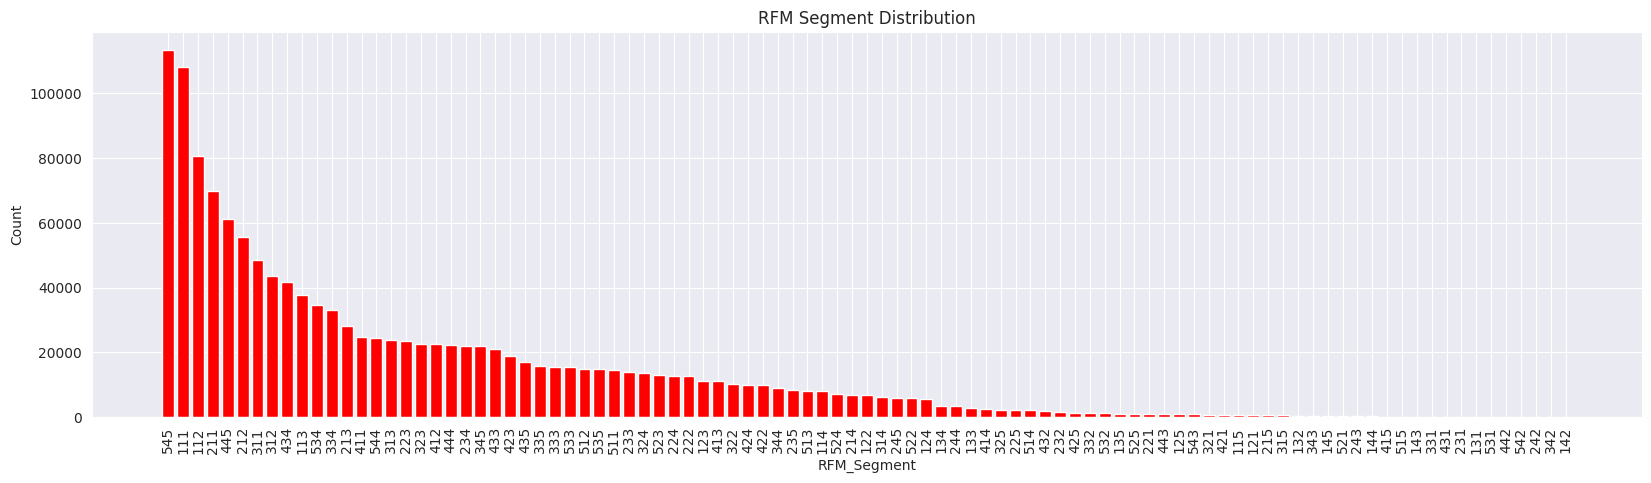

In [49]:
# RFM_Segment as x and Count as y
count = rfm_df['RFM_Segment'].value_counts().values
segment = rfm_df['RFM_Segment'].value_counts().index
plt.figure(figsize=(20, 5))
plt.xticks(rotation=90)
plt.xlabel('RFM_Segment')
plt.ylabel('Count')
plt.title('RFM Segment Distribution')
plt.bar(segment, count, color='red')

<BarContainer object of 12 artists>

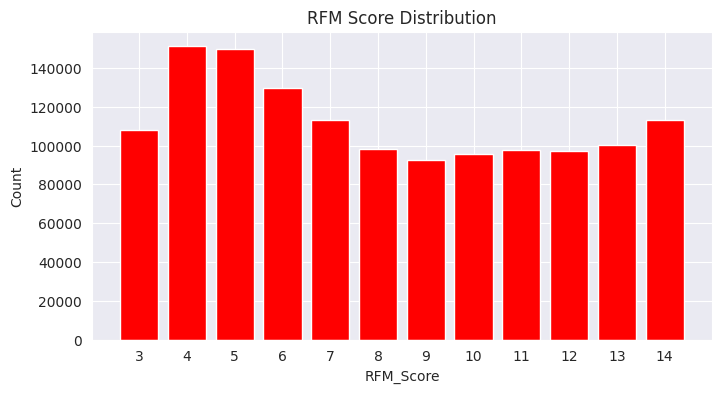

In [50]:
# RFM_Score as x and Count as y
count = rfm_df['RFM_Score'].value_counts().values
score = rfm_df['RFM_Score'].value_counts().index
plt.figure(figsize=(8, 4))
plt.xlabel('RFM_Score')
plt.ylabel('Count')
plt.xticks(np.arange(3, 15, 1))
plt.title('RFM Score Distribution')
plt.bar(score, count, color='red')

## Step 3.3: Customer segmentation based on RFM scores
* best customer: high R, F, M - RFM segment: 545
* loyal customer: high F, (R) - RFM segment: 54X (X=1,2,3,4,5)
* big spender: high M, low R and F - RFM segment: YY5 (Y=1,2)
* at-risk customer: high F, M, and low R - RFM segment: Y45 (Y=1,2)
* new customer: high R, low F and M - RFM segment: 51Y (Y=1,2)
* occasional customers: score is in the middle like 333 - RFM segment: 3YX (Y=2,3) (X=1,2,3,4,5)

**Customer Segmentation**

In [51]:
# Best customer
best_customer = rfm_df[rfm_df['RFM_Segment'] == '545']
best_customer_id = best_customer['customer_id'].unique().tolist()
best_transactions = transactions[transactions['customer_id'].isin(best_customer_id)]

# Loyal customer
loyal_customer = rfm_df[rfm_df['RFM_Segment'].str.match('^54.$')]
loyal_customer_id = loyal_customer['customer_id'].unique().tolist()
loyal_transactions = transactions[transactions['customer_id'].isin(loyal_customer_id)]

# Big spender
big_spender_id = rfm_df[(rfm_df['M'] == '5') & 
                        ((rfm_df['R'] == '1')|(rfm_df['R']=='2'))&
                        ((rfm_df['F']== '1')|(rfm_df['F']=='2'))]
big_spender_id = big_spender_id['customer_id'].unique().tolist()
big_spender = transactions[transactions['customer_id'].isin(big_spender_id)]

# At-risk customer
at_risk_id = rfm_df[((rfm_df['R'] == '1')|(rfm_df['R']=='2'))&
                        (rfm_df['F']=='4')&(rfm_df['M'] == '5')]
at_risk_id = at_risk_id['customer_id'].unique().tolist()
at_risk = transactions[transactions['customer_id'].isin(at_risk_id)]

# New customer
rfm_df_with_customer_id = rfm_df.reset_index().copy()
new_customer = rfm_df_with_customer_id[(rfm_df_with_customer_id['RFM_Segment'] == '511') 
                                       | (rfm_df_with_customer_id['RFM_Segment'] == '512')]
new_customer_merged = pd.merge(new_customer, transactions, on='customer_id')

# Occasional customer
occasional_customer = get_customer_segment(rfm_df, ['3'], ['2', '3'], ['1', '2', '3', '4', '5'])
occasional_customer_merged = pd.merge(occasional_customer, transactions, on='customer_id')

### Age Distribution

**Best Customers** and **Loyal Customers** have a median age of 31, with the most common age range falling between 24 to 28.30 years.

**Big Spenders** appears slightly older with a median age of 34. The age range that occurs most frequently is 27.30 to 30.40 years, suggesting these customers may be in a higher income bracket associated with more advanced career stages.

**At-risk Customers** have a median age of 33, with a key age range between 21 to 25.20 years. The distribution is less skewed towards younger ages.

**New Customers** show the youngest median age of 28, with the most common age range being from 19.80 to 23.60 years, indicating recent customer acquisitions are generally younger.

**Occasional Customers** have a median age of 31, similar to Best and Loyal Customers. The predominant age range is 20.10 to 24.20 years, highlighting that these customers, while not purchasing as frequently, still fall within a younger demographic.

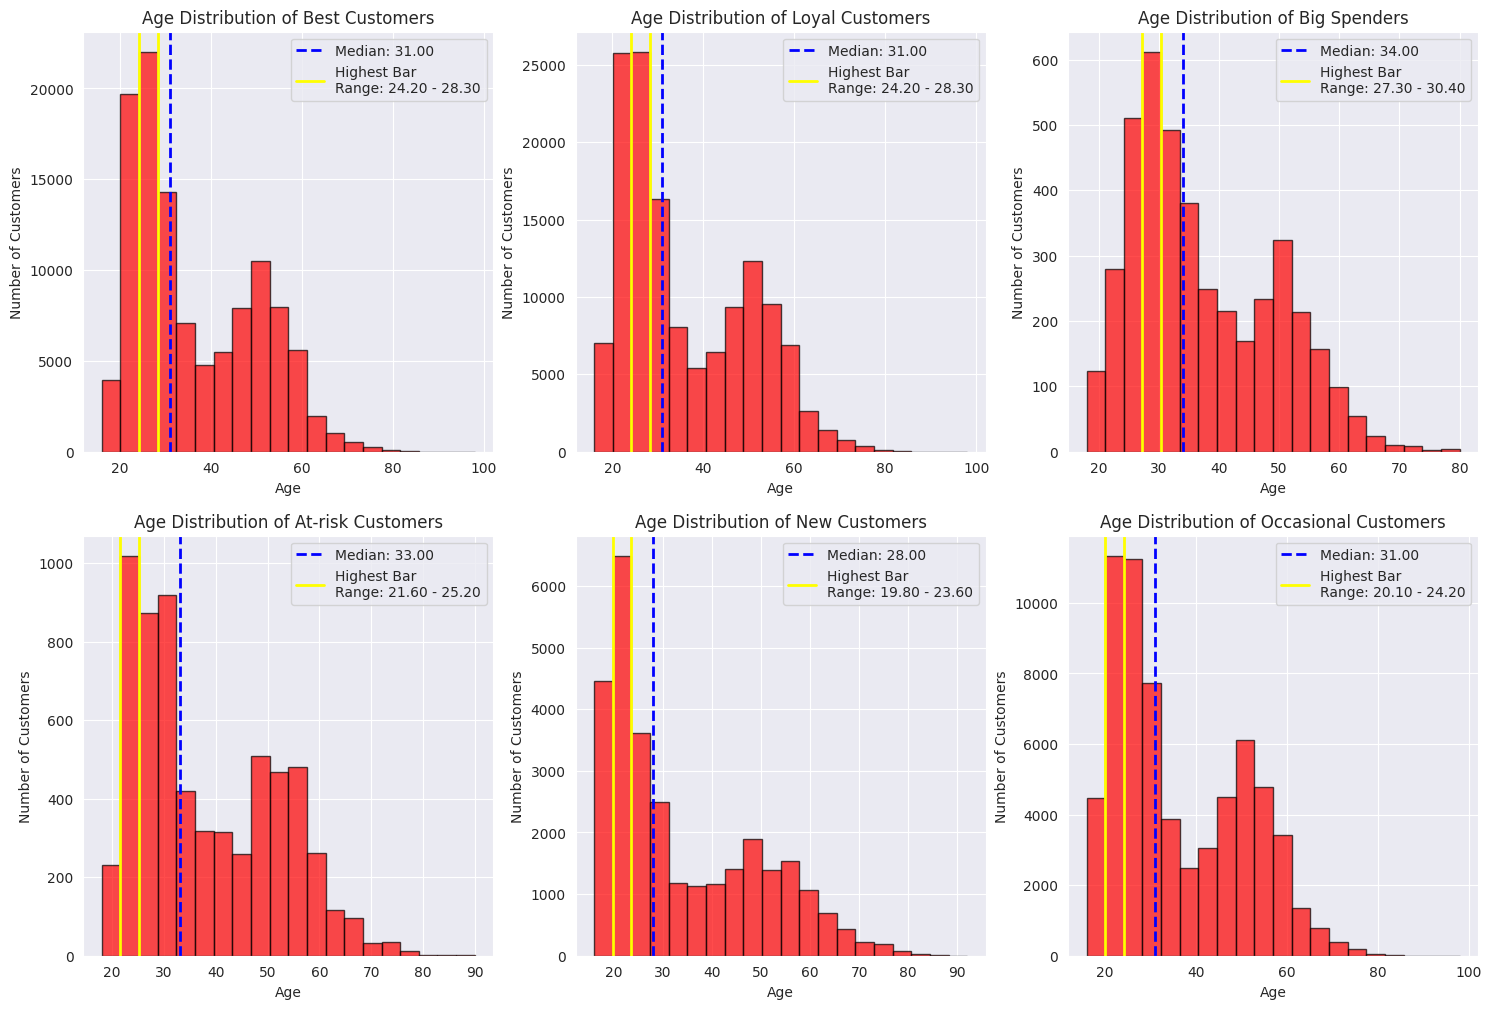

In [52]:
# Pre-processing
best_age = best_transactions.drop_duplicates(subset=['customer_id'])[['customer_id', 'age']]
best_customer_median = np.median(best_age['age'])

loyal_age = loyal_transactions.drop_duplicates(subset=['customer_id'])[['customer_id', 'age']]
loyal_customer_median = np.median(loyal_age['age'])

big_spender_age = big_spender.drop_duplicates(subset=['customer_id'])[['customer_id', 'age']]
big_spender_median = np.median(big_spender_age['age'])

at_risk_age = at_risk.drop_duplicates(subset=['customer_id'])[['customer_id', 'age']]
at_risk_median = np.median(at_risk_age['age'])

new_customer_merged_age = new_customer_merged.drop_duplicates(subset=['customer_id'])[['customer_id', 'age']]
new_customer_merged_median = np.median(new_customer_merged_age['age'])

occasional_customer_merged_age = occasional_customer_merged.drop_duplicates(subset=['customer_id'])[['customer_id', 'age']]
occasional_customer_merged_median = np.median(occasional_customer_merged_age['age'])


plt.figure(figsize=(18, 12))

# Best customer
plt.subplot(2, 3, 1)
n, bins, patches = plt.hist(best_age['age'], color='red', bins=20, edgecolor='k', alpha=0.7)
highest_bar_index = np.argmax(n)
highest_bar_range_start = bins[highest_bar_index]
highest_bar_range_end = bins[highest_bar_index + 1]
plt.title('Age Distribution of Best Customers')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.axvline(best_customer_median, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {best_customer_median:.2f}')
plt.axvline(highest_bar_range_start, color='yellow', linestyle='solid', linewidth=2, label=f'Highest Bar\nRange: {highest_bar_range_start:.2f} - {highest_bar_range_end:.2f}')
plt.axvline(highest_bar_range_end, color='yellow', linestyle='solid', linewidth=2)
plt.grid(True)
plt.legend()

# Loyal customer
plt.subplot(2, 3, 2)
n, bins, patches = plt.hist(loyal_age['age'], color='red', bins=20, edgecolor='k', alpha=0.7)
highest_bar_index = np.argmax(n)
highest_bar_range_start = bins[highest_bar_index]
highest_bar_range_end = bins[highest_bar_index + 1]
plt.title('Age Distribution of Loyal Customers')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.axvline(loyal_customer_median, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {loyal_customer_median:.2f}')
plt.axvline(highest_bar_range_start, color='yellow', linestyle='solid', linewidth=2, label=f'Highest Bar\nRange: {highest_bar_range_start:.2f} - {highest_bar_range_end:.2f}')
plt.axvline(highest_bar_range_end, color='yellow', linestyle='solid', linewidth=2)
plt.grid(True)
plt.legend()

# Big spender
plt.subplot(2, 3, 3)
n, bins, patches = plt.hist(big_spender_age['age'],color='red', bins=20, edgecolor='k', alpha=0.7)
highest_bar_index = np.argmax(n)
highest_bar_range_start = bins[highest_bar_index]
highest_bar_range_end = bins[highest_bar_index + 1]
plt.title('Age Distribution of Big Spenders')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.axvline(big_spender_median, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {big_spender_median:.2f}')
plt.axvline(highest_bar_range_start, color='yellow', linestyle='solid', linewidth=2, label=f'Highest Bar\nRange: {highest_bar_range_start:.2f} - {highest_bar_range_end:.2f}')
plt.axvline(highest_bar_range_end, color='yellow', linestyle='solid', linewidth=2)
plt.grid(True)
plt.legend()

# At-risk customer
plt.subplot(2, 3, 4)
n, bins, patches =plt.hist(at_risk_age['age'], color='red', bins=20, edgecolor='k', alpha=0.7)
highest_bar_index = np.argmax(n)
highest_bar_range_start = bins[highest_bar_index]
highest_bar_range_end = bins[highest_bar_index + 1]
plt.title('Age Distribution of At-risk Customers')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.axvline(at_risk_median, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {at_risk_median:.2f}')
plt.axvline(highest_bar_range_start, color='yellow', linestyle='solid', linewidth=2, label=f'Highest Bar\nRange: {highest_bar_range_start:.2f} - {highest_bar_range_end:.2f}')
plt.axvline(highest_bar_range_end, color='yellow', linestyle='solid', linewidth=2)
plt.grid(True)
plt.legend()

# New customers
plt.subplot(2, 3, 5)
n, bins, patches =plt.hist(new_customer_merged_age['age'], color='red', bins=20, edgecolor='k', alpha=0.7)
highest_bar_index = np.argmax(n)
highest_bar_range_start = bins[highest_bar_index]
highest_bar_range_end = bins[highest_bar_index + 1]
plt.title('Age Distribution of New Customers')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.axvline(new_customer_merged_median, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {new_customer_merged_median:.2f}')
plt.axvline(highest_bar_range_start, color='yellow', linestyle='solid', linewidth=2, label=f'Highest Bar\nRange: {highest_bar_range_start:.2f} - {highest_bar_range_end:.2f}')
plt.axvline(highest_bar_range_end, color='yellow', linestyle='solid', linewidth=2)
plt.grid(True)
plt.legend()

# Occasional customer
plt.subplot(2, 3, 6)
n, bins, patches =plt.hist(occasional_customer_merged_age['age'], color='red', bins=20, edgecolor='k', alpha=0.7)
highest_bar_index = np.argmax(n)
highest_bar_range_start = bins[highest_bar_index]
highest_bar_range_end = bins[highest_bar_index + 1]
plt.title('Age Distribution of Occasional Customers')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.axvline(occasional_customer_merged_median, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {occasional_customer_merged_median:.2f}')
plt.axvline(highest_bar_range_start, color='yellow', linestyle='solid', linewidth=2, label=f'Highest Bar\nRange: {highest_bar_range_start:.2f} - {highest_bar_range_end:.2f}')
plt.axvline(highest_bar_range_end, color='yellow', linestyle='solid', linewidth=2)
plt.grid(True)
plt.legend()

plt.show()

### Generation Distribution

* **Gen Z is the predominant demographic, indicating they are highly engaged with the brand and represent a significant portion of the customer base.**
* **Millennials are notably the biggest spenders and also constitute a substantial share of best and loyal customers, suggesting they have considerable spending power and loyalty to the brand.**
* **Gen X appears consistently as the third-largest segment across all customer behaviors, indicating a reliable and steady presence within the customer base.**
* **Baby Boomers have a smaller representation overall, with a slightly higher presence in the at-risk category, which might signal a need for re-engagement strategies to retain them.**
* **Silent Generation and Greatest Gen have minimal to no presence, suggesting limited engagement with the brand, possibly due to generational preferences or market reach.**

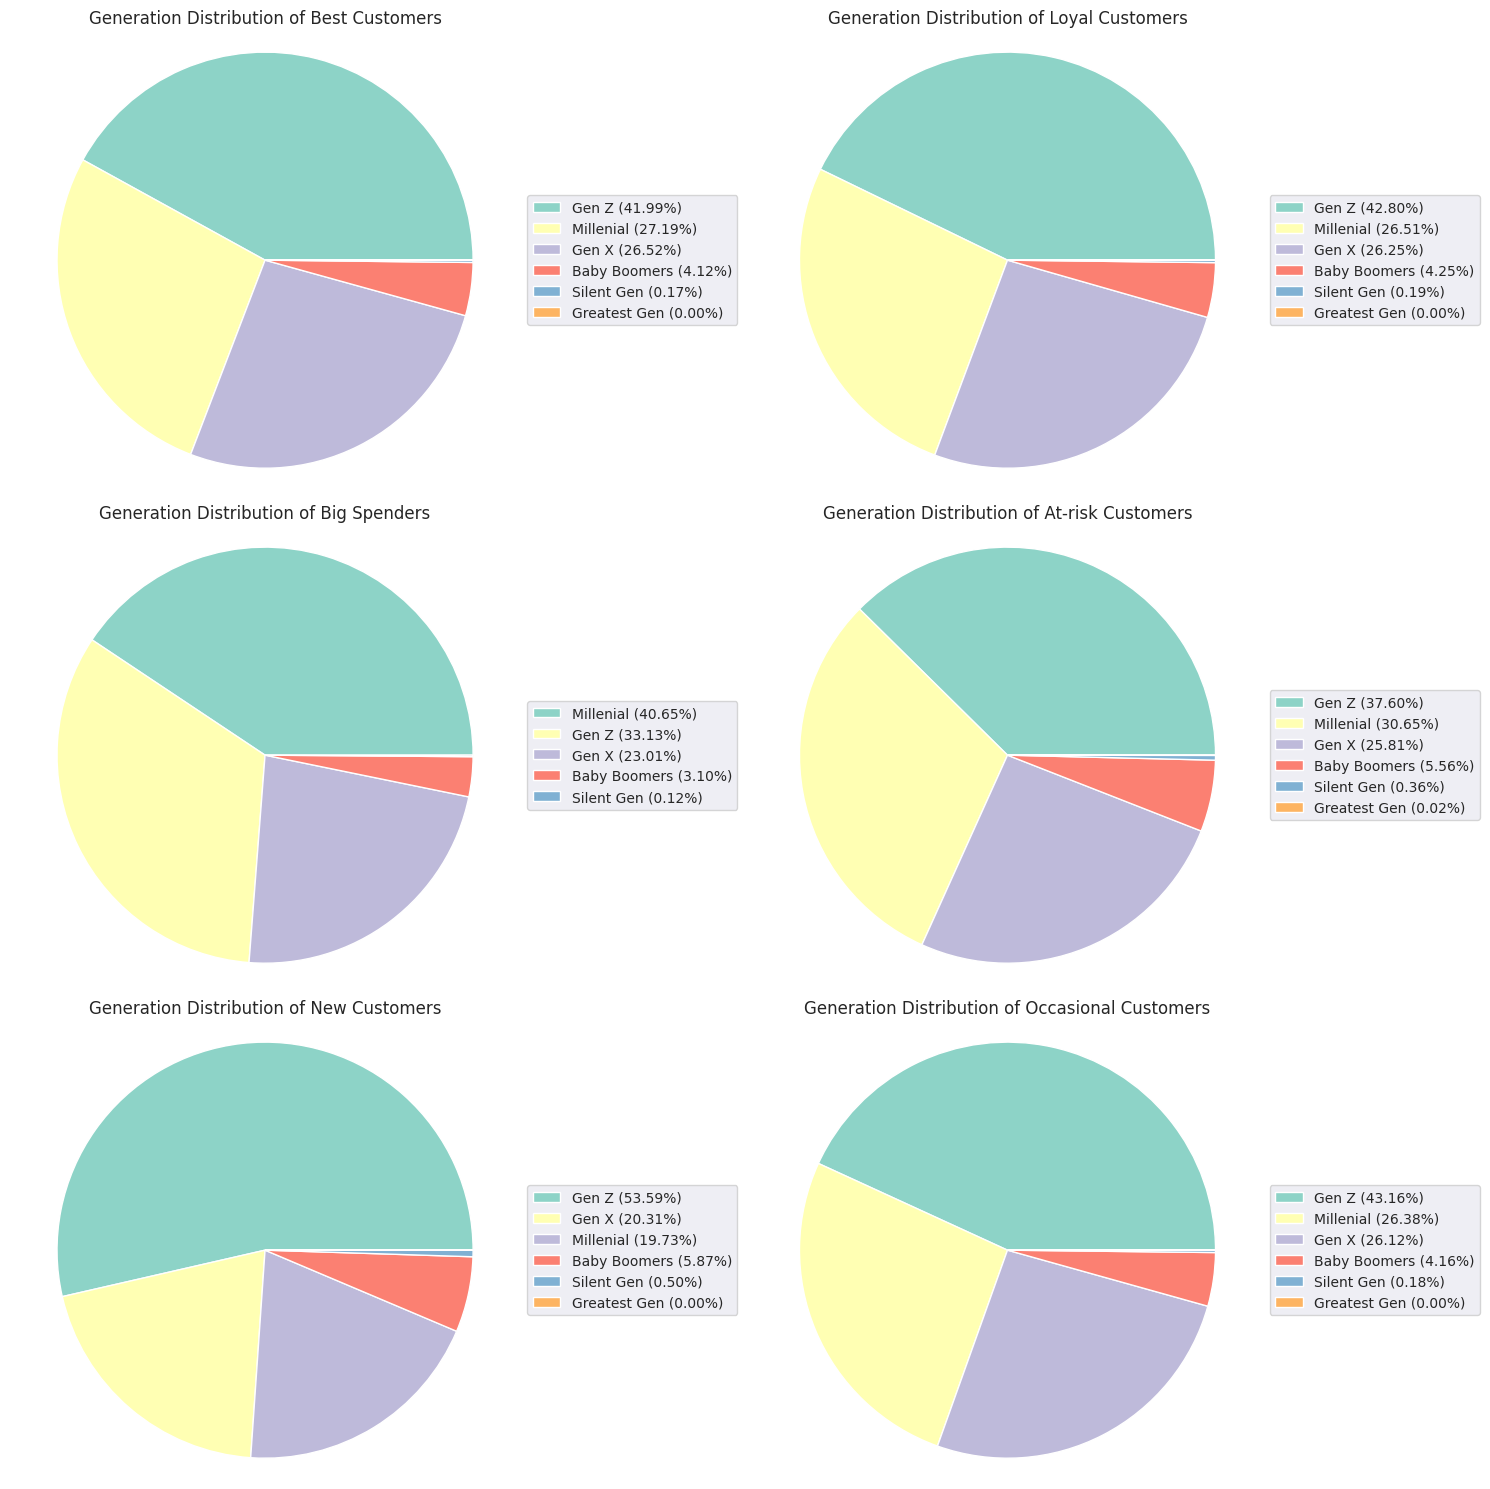

In [53]:
best_gen_counts = best_transactions['age_group'].value_counts()
best_gen_counts_dict = dict(best_gen_counts)

loyal_gen_counts = loyal_transactions['age_group'].value_counts()
loyal_gen_counts_dict = dict(loyal_gen_counts)

big_spender_counts = big_spender['age_group'].value_counts()
big_spender_counts_dict = dict(big_spender_counts)

at_risk_counts = at_risk['age_group'].value_counts()
at_risk_counts_dict = dict(at_risk_counts)

new_customer_merged_counts = new_customer_merged['age_group'].value_counts()
new_customer_merged_counts_dict = dict(new_customer_merged_counts)

occasional_customer_merged_counts = occasional_customer_merged['age_group'].value_counts()
occasional_customer_merged_counts_dict = dict(occasional_customer_merged_counts)


plt.figure(figsize=(15, 15))

# Best customers
plt.subplot(3, 2, 1)
plt.pie(best_gen_counts, colors=sns.color_palette('Set3'))
plt.axis('equal')
plt.title('Generation Distribution of Best Customers')
best_gen_percentages = [f'{best_gen_counts_dict[key]/sum(best_gen_counts_dict.values())*100:.2f}%' for key in best_gen_counts_dict.keys()]
plt.legend(labels=[f'{label} ({percent})' for label, percent in zip(best_gen_counts_dict.keys(), best_gen_percentages)], loc="center left", bbox_to_anchor=(1, 0.5))

# Loyal customers
plt.subplot(3, 2, 2)
plt.pie(loyal_gen_counts, colors=sns.color_palette('Set3'))
plt.axis('equal')
plt.title('Generation Distribution of Loyal Customers')
loyal_gen_percentages = [f'{loyal_gen_counts_dict[key]/sum(loyal_gen_counts_dict.values())*100:.2f}%' for key in loyal_gen_counts_dict.keys()]
plt.legend(labels=[f'{label} ({percent})' for label, percent in zip(loyal_gen_counts_dict.keys(), loyal_gen_percentages)], loc="center left", bbox_to_anchor=(1, 0.5))

# Big spender
plt.subplot(3, 2, 3)
plt.pie(big_spender_counts, colors=sns.color_palette('Set3'))
plt.axis('equal')
plt.title('Generation Distribution of Big Spenders')
big_spender_percentages = [f'{big_spender_counts_dict[key]/sum(big_spender_counts_dict.values())*100:.2f}%' for key in big_spender_counts_dict.keys()] 
plt.legend(labels=[f'{label} ({percent})' for label, percent in zip(big_spender_counts_dict.keys(), big_spender_percentages)], loc="center left", bbox_to_anchor=(1, 0.5))

# At-risk customers
plt.subplot(3, 2, 4)
plt.pie(at_risk_counts, colors=sns.color_palette('Set3'))
plt.axis('equal')
plt.title('Generation Distribution of At-risk Customers')
at_risk_percentages = [f'{at_risk_counts_dict[key]/sum(at_risk_counts_dict.values())*100:.2f}%' for key in at_risk_counts_dict.keys()] 
plt.legend(labels=[f'{label} ({percent})' for label, percent in zip(at_risk_counts_dict.keys(), at_risk_percentages)], loc="center left", bbox_to_anchor=(1, 0.5))

# New customers
plt.subplot(3, 2, 5)
plt.pie(new_customer_merged_counts, colors=sns.color_palette('Set3'))
plt.axis('equal')
plt.title('Generation Distribution of New Customers')
new_percentages = [f'{new_customer_merged_counts_dict[key]/sum(new_customer_merged_counts_dict.values())*100:.2f}%' for key in new_customer_merged_counts_dict.keys()] 
plt.legend(labels=[f'{label} ({percent})' for label, percent in zip(new_customer_merged_counts_dict.keys(), new_percentages)], loc="center left", bbox_to_anchor=(1, 0.5))

# Occasional customers
plt.subplot(3, 2, 6)
plt.pie(occasional_customer_merged_counts, colors=sns.color_palette('Set3'))
plt.axis('equal')
plt.title('Generation Distribution of Occasional Customers')
occasional_percentages = [f'{occasional_customer_merged_counts_dict[key]/sum(occasional_customer_merged_counts_dict.values())*100:.2f}%' for key in occasional_customer_merged_counts_dict.keys()] 
plt.legend(labels=[f'{label} ({percent})' for label, percent in zip(occasional_customer_merged_counts_dict.keys(), occasional_percentages)], loc="center left", bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.show()

### Day of the Week Distribution

* **Different customer segments have different preferences for their shopping day of week, which is good for a balanced shopping traffic and targeted marketing strategy.**
* **According to the Top 2 for each customer segments, Saturday and Wednesday are the hottest shopping days of week in general.**
    * Best customers: Sat. and Wed.
    * Loyal customers: Sat. and Wed.
    * Big spender: Sun. and Wed.
    * At-risk customers: Wed. and Thurs.
    * New customers: Thurs. and Sat.
    * Occasional customers: Sat. and Thurs.
* **Big spenders have an unusual transaction spike on Sundays.**

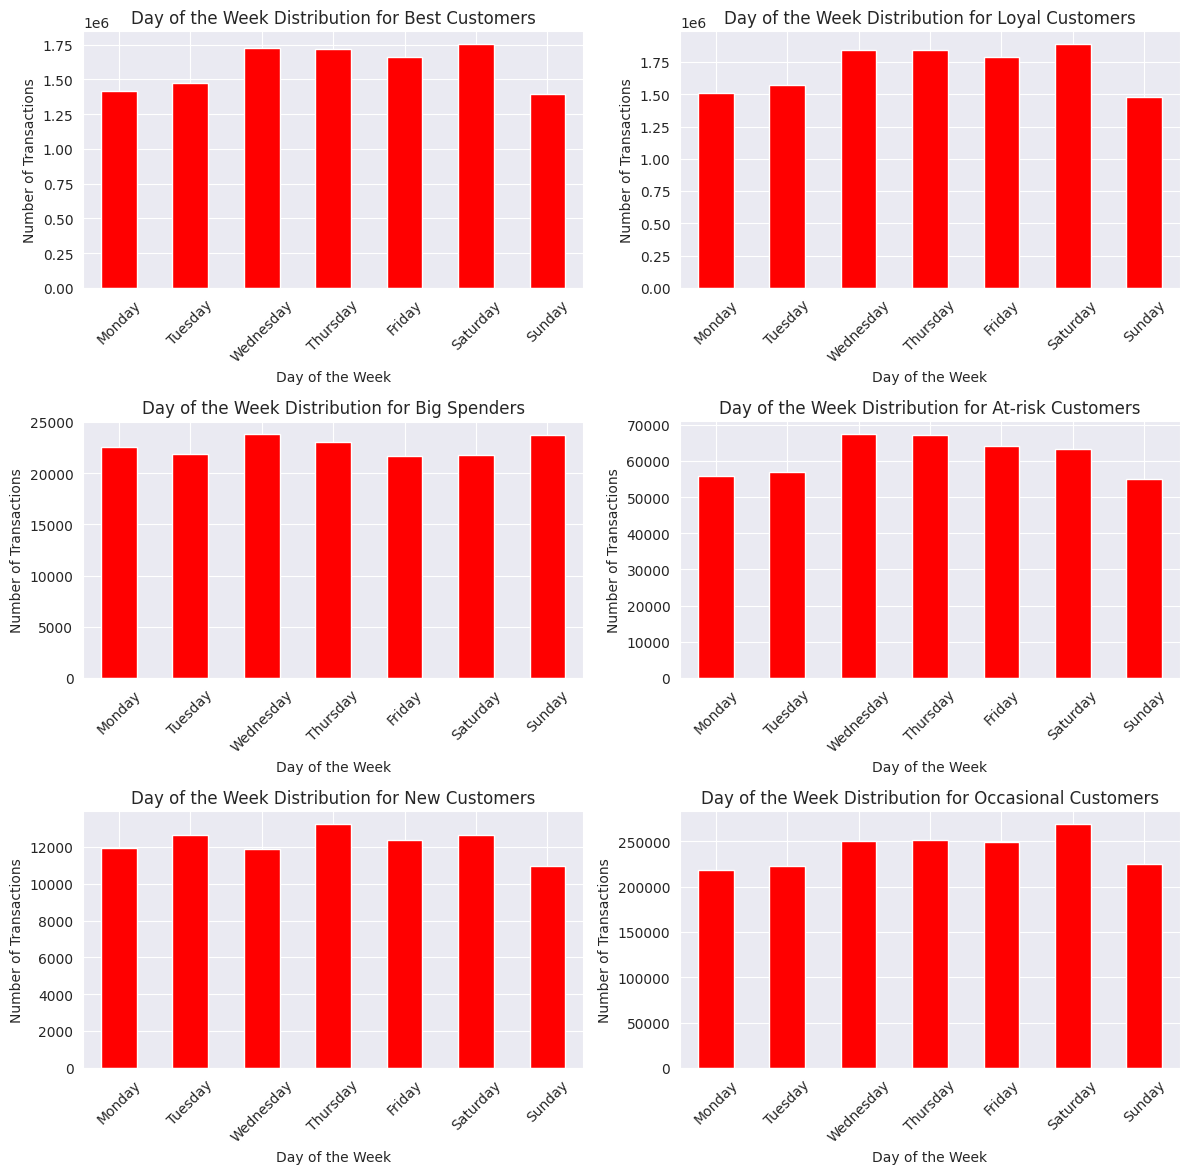

In [54]:
# Define the desired order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 12))

# Best customers
plt.subplot(3, 2, 1)
best_transactions['day_of_week'] = pd.Categorical(best_transactions['day_of_week'], categories=day_order, ordered=True)
best_transactions['day_of_week'].value_counts().sort_index().plot(kind='bar', color='red')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.title('Day of the Week Distribution for Best Customers')
plt.xticks(rotation=45)

# Loyal customers
plt.subplot(3, 2, 2)
loyal_transactions['day_of_week'] = pd.Categorical(loyal_transactions['day_of_week'], categories=day_order, ordered=True)
loyal_transactions['day_of_week'].value_counts().sort_index().plot(kind='bar', color='red')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.title('Day of the Week Distribution for Loyal Customers')
plt.xticks(rotation=45)

# Big spender
plt.subplot(3, 2, 3)
big_spender['day_of_week'] = pd.Categorical(big_spender['day_of_week'], categories=day_order, ordered=True)
big_spender['day_of_week'].value_counts().sort_index().plot(kind='bar', color='red')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.title('Day of the Week Distribution for Big Spenders')
plt.xticks(rotation=45)

# At-risk customers
plt.subplot(3, 2, 4)
at_risk['day_of_week'] = pd.Categorical(at_risk['day_of_week'], categories=day_order, ordered=True)
at_risk['day_of_week'].value_counts().sort_index().plot(kind='bar', color='red')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.title('Day of the Week Distribution for At-risk Customers')
plt.xticks(rotation=45)

# New customers
plt.subplot(3, 2, 5)
new_customer_merged['day_of_week'] = pd.Categorical(new_customer_merged['day_of_week'], categories=day_order, ordered=True)
new_customer_merged['day_of_week'].value_counts().sort_index().plot(kind='bar', color='red')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.title('Day of the Week Distribution for New Customers')
plt.xticks(rotation=45)

# Occasional customers
plt.subplot(3, 2, 6)
occasional_customer_merged['day_of_week'] = pd.Categorical(occasional_customer_merged['day_of_week'], categories=day_order, ordered=True)
occasional_customer_merged['day_of_week'].value_counts().sort_index().plot(kind='bar', color='red')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.title('Day of the Week Distribution for Occasional Customers')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

# Step 4: Deep dive into the most valuable customer segment


In [55]:
most_valuable_customer = rfm_df[rfm_df['RFM_Segment'] == '545']
most_valuable_customer.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
12,14,24,25,2954.312256,5,4,5,545,14
28,30,29,21,623.042114,5,4,5,545,14
37,39,9,144,15026.172852,5,4,5,545,14
53,56,15,20,1243.883057,5,4,5,545,14
94,97,26,22,652.147766,5,4,5,545,14


In [56]:
# Merge most valuable customer RFM result with transactions
most_valuable_customer = pd.merge(transactions, most_valuable_customer, on='customer_id')
most_valuable_customer.head()

,t_dat,customer_id,article_id,price,sales_channel,day_of_week,age,age_group,product_code,prod_name,...,garment_group_name,detail_desc,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,2018-09-20,204,531310002,13.287964,Online,Thursday,50.0,Gen X,531310,Drew Cardigan,...,Knitwear,"Long cardigan in a soft, fine knit containing ...",9,37,892.740051,5,4,5,545,14
1,2018-09-20,204,529841001,11.991577,Online,Thursday,50.0,Gen X,529841,Lauper Sweater,...,Knitwear,Jumper in a marled knit containing some wool w...,9,37,892.740051,5,4,5,545,14
2,2018-09-20,660,652075001,6.990585,Online,Thursday,25.0,Gen Z,652075,Stork fancy,...,Jersey Fancy,Off-the-shoulder blouse in crinkled jersey wit...,3,21,592.237183,5,4,5,545,14
3,2018-09-20,660,670295001,5.991287,Online,Thursday,25.0,Gen Z,670295,CSP Hackney tank,...,Jersey Fancy,Cropped top in ribbed jersey with a V-neck at ...,3,21,592.237183,5,4,5,545,14
4,2018-09-20,1254,617322003,19.985962,In-store,Thursday,27.0,Gen Z,617322,HM+ Glans tunic,...,Jersey Fancy,Long-sleeved tunic in jersey crêpe with a roun...,16,55,2243.136230,5,4,5,545,14


## Step 4.1: What kinds of products do the most valuable customer segment like most?

Expectation: This demographic typically leans towards trendy, affordable, and sustainable clothing. For example, H&M's Conscious collection, which emphasizes sustainability, might be particularly attractive to them.

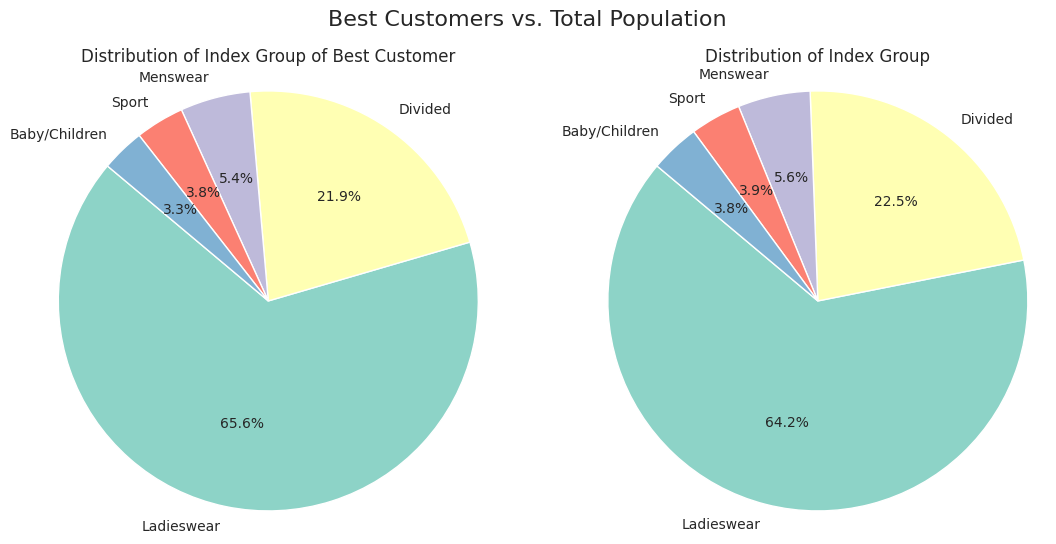

In [57]:
index_group_counts = most_valuable_customer['index_group_name'].value_counts()
total_index_counts = transactions['index_group_name'].value_counts()

plt.figure(figsize=(13, 6)) 

plt.subplot(1,2,1)
plt.pie(index_group_counts, labels = index_group_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
plt.axis('equal')
plt.title('Distribution of Index Group of Best Customer')

plt.subplot(1,2,2)
plt.pie(total_index_counts, labels = total_index_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
plt.axis('equal')
plt.title('Distribution of Index Group')

plt.suptitle('Best Customers vs. Total Population', fontsize=16)

plt.show()

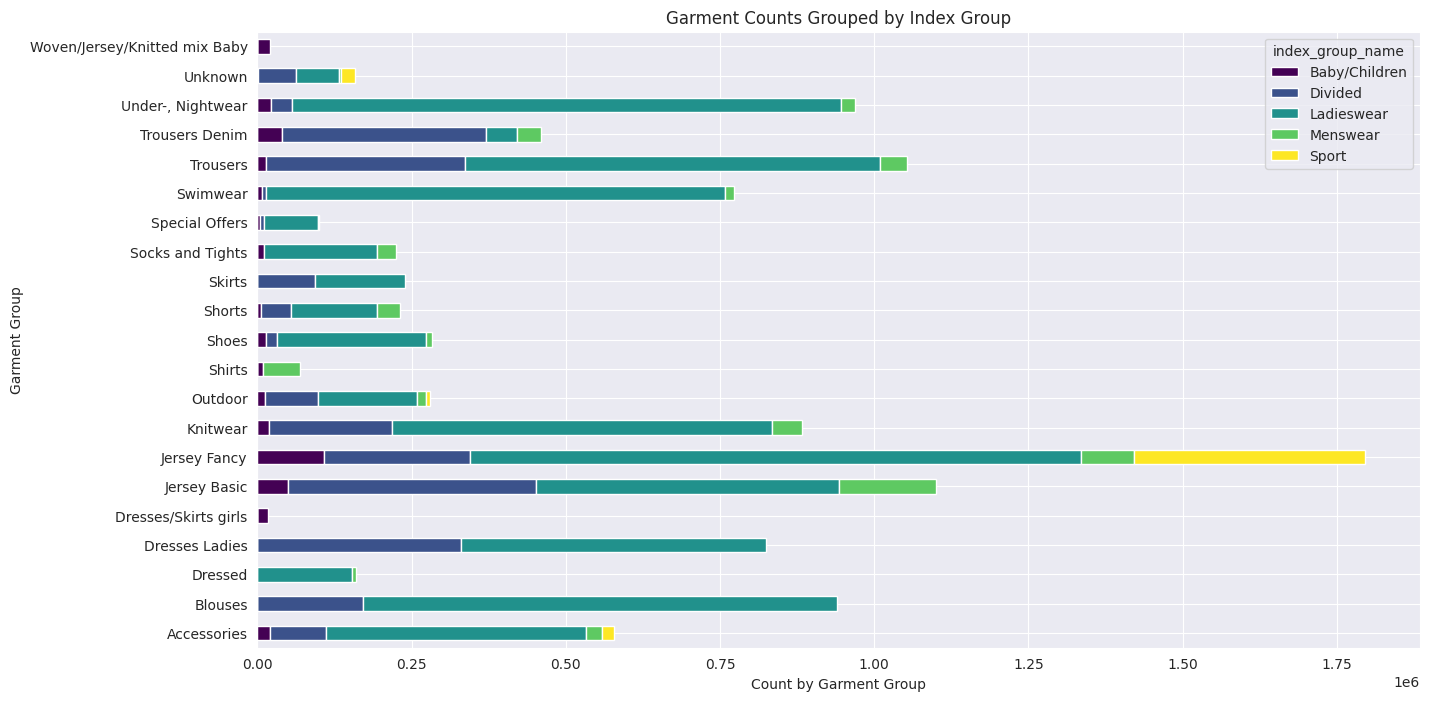

In [58]:
pivot_df = most_valuable_customer.pivot_table(index='garment_group_name', columns='index_group_name', aggfunc='size', fill_value=0)

pivot_df.plot(kind='barh', stacked=True, figsize=(15, 8), colormap='viridis')

plt.xlabel('Count by Garment Group')
plt.ylabel('Garment Group')
plt.title('Garment Counts Grouped by Index Group')
plt.show()

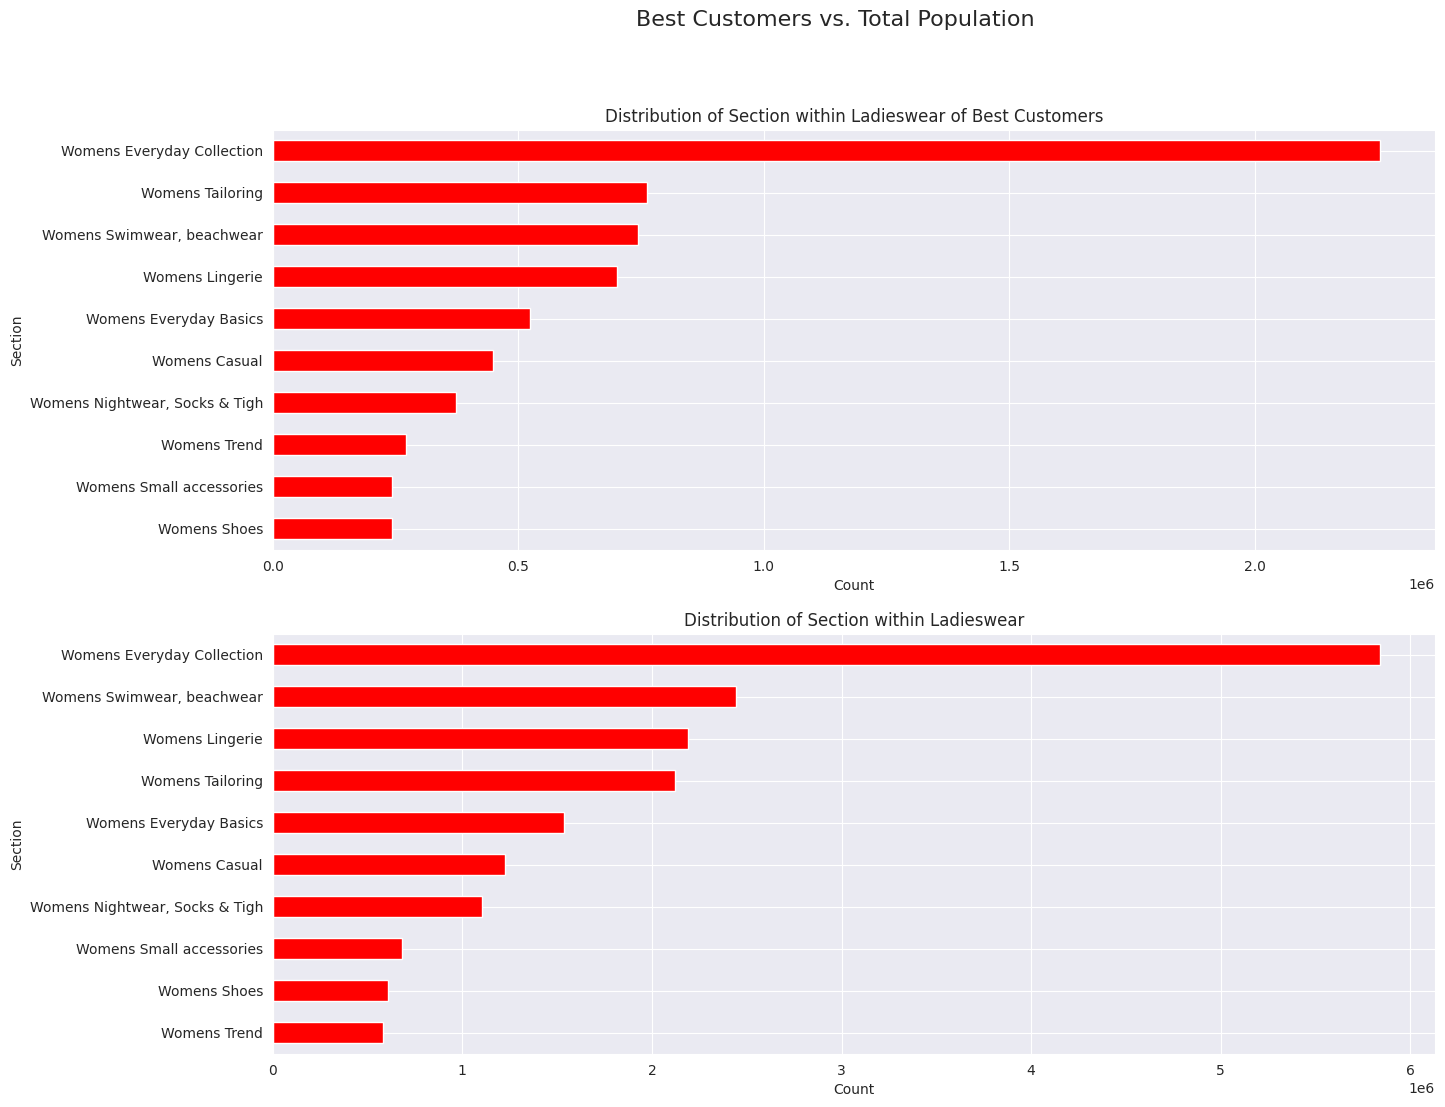

In [59]:
ladieswear_df = most_valuable_customer[most_valuable_customer['index_group_name'] == 'Ladieswear']
section_counts = ladieswear_df['section_name'].value_counts()
section_counts = section_counts[section_counts>0].sort_values().tail(10)

total_ladieswear_df = transactions[transactions['index_group_name'] == 'Ladieswear']
total_section_counts = total_ladieswear_df['section_name'].value_counts()
total_section_counts = total_section_counts[total_section_counts>0].sort_values().tail(10)

plt.figure(figsize=(15, 12)) 

plt.subplot(2,1,1)
bars = section_counts.plot(kind='barh', color='red')
plt.xlabel('Count')
plt.ylabel('Section')
plt.title('Distribution of Section within Ladieswear of Best Customers')

plt.subplot(2,1,2)
bars = total_section_counts.plot(kind='barh', color='red')
plt.xlabel('Count')
plt.ylabel('Section')
plt.title('Distribution of Section within Ladieswear')

    
plt.suptitle('Best Customers vs. Total Population', fontsize=16)

plt.show()

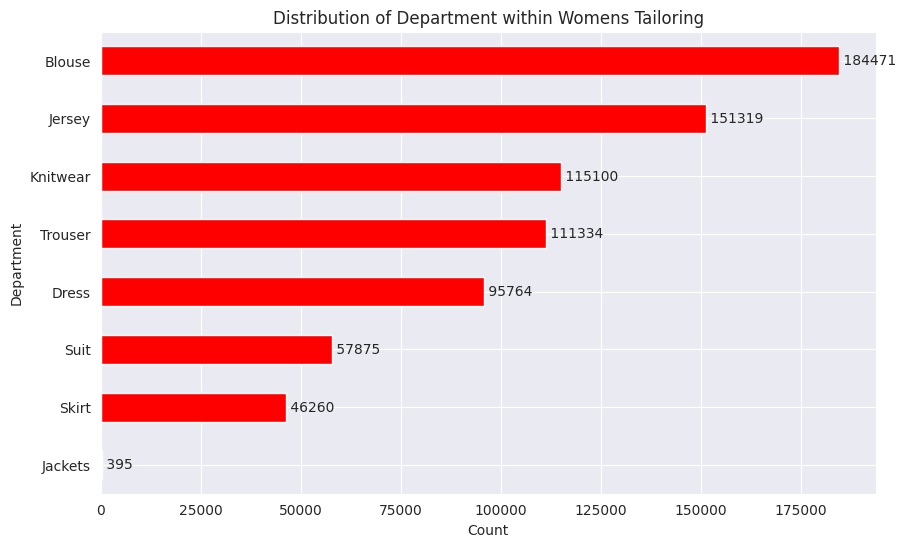

In [60]:
wt_df = ladieswear_df[ladieswear_df['section_name'] == 'Womens Tailoring']

department_counts = wt_df['department_name'].value_counts()

department_counts = department_counts[department_counts>0].sort_values()

# Plot the results as a bar chart
plt.figure(figsize=(10, 6)) 
bars = department_counts.plot(kind='barh', color='red')
plt.xlabel('Count')
plt.ylabel('Department')
plt.title('Distribution of Department within Womens Tailoring')

for bar in bars.patches:
    plt.text(
        bar.get_width(),      
        bar.get_y() + bar.get_height() / 2,  
        f' {int(bar.get_width())}', 
        va='center'  
    )

plt.show()

In [61]:
jf_df = wt_df[wt_df['department_name'] == 'Blouse']
product_count_per_group = jf_df.groupby(['product_group_name', 'product_type_name','graphical_appearance_name','perceived_colour_master_name']).count()['article_id']
product_count_per_group = pd.DataFrame(product_count_per_group).reset_index()
product_count_per_group.rename(columns={'article_id': 'count'}, inplace=True)
product_count_per_group = product_count_per_group.sort_values(['count'], ascending = False)
product_count_per_group.head(10)

,product_group_name,product_type_name,graphical_appearance_name,perceived_colour_master_name,count
557316,Garment Upper body,Blouse,Solid,White,39373
602316,Garment Upper body,Shirt,Solid,White,18063
557301,Garment Upper body,Blouse,Solid,Black,11268
556800,Garment Upper body,Blouse,All over pattern,Beige,8318
602301,Garment Upper body,Shirt,Solid,Black,8268
557312,Garment Upper body,Blouse,Solid,Pink,7984
623316,Garment Upper body,Vest top,Solid,White,7621
557302,Garment Upper body,Blouse,Solid,Blue,7174
556816,Garment Upper body,Blouse,All over pattern,White,5409
557305,Garment Upper body,Blouse,Solid,Green,5185


**Insights**
* Preference for Womens Tailoring section:
Compares to total population, the most valuable customers purchase more products from the
Womens Tailoring section. A preference for tailored garments indicates a value placed on quality, craftsmanship, and fit. These customers may prioritize how clothes fit and complement their body type over general fashion trends. The tendency to purchase semi-formal attire suggests that these customers may have professional or social obligations that require a certain dress code.

* Popularity of Blouses :
Blouses are highly popular in the Womens Tailoring section. This could indicate a demand for formal or semi-formal upper body garments, possibly for professional settings or occasions that require a smart-casual dress code.

* Preference for Solid Colors and Basics:
The dominant presence of "Solid" under graphical_appearance_name across various items indicates a strong preference for solid colors over patterns. This could suggest that customers favor classic, versatile pieces that are easier to pair with other items.

* White and Black are Top Color Choices:
White and black are the most common colors for the top purchased items, indicating a preference for these versatile, classic colors that can easily fit into most wardrobes and are suitable for a wide range of occasions.

## Step 4.2: What are the purchasing behaviors of the most valuable customers?

In [62]:
# Analyze purchasing behavior of the most valuable customers
purchase_amount = most_valuable_customer['price']
seasonality = most_valuable_customer['t_dat'].apply(lambda x: x.month).value_counts()
online_vs_instore = most_valuable_customer['sales_channel'].value_counts()

In [63]:
# Get purchaseing behavoir of the general population
purchase_amount_general = transactions['price']
seasonality_general = transactions['t_dat'].apply(lambda x: x.month).value_counts()
online_vs_instore_general = transactions['sales_channel'].value_counts()

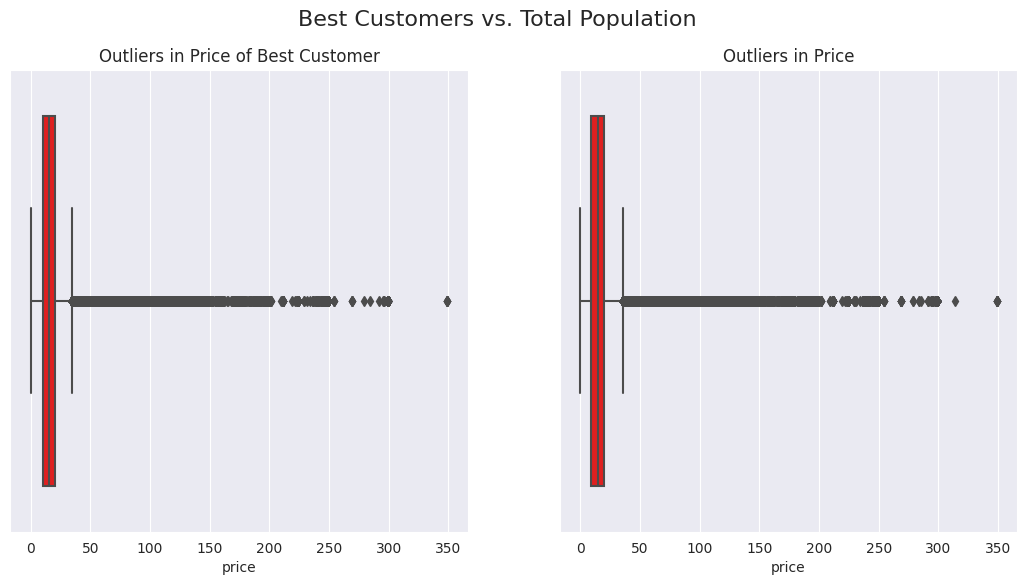

In [64]:
plt.figure(figsize=(13, 6)) 

plt.subplot(1,2,1)
sns.boxplot(x=purchase_amount, color='red')
plt.title("Outliers in Price of Best Customer")

plt.subplot(1,2,2)
sns.boxplot(x=purchase_amount_general, color='red')
plt.title("Outliers in Price")

plt.suptitle('Best Customers vs. Total Population', fontsize=16)

plt.show()

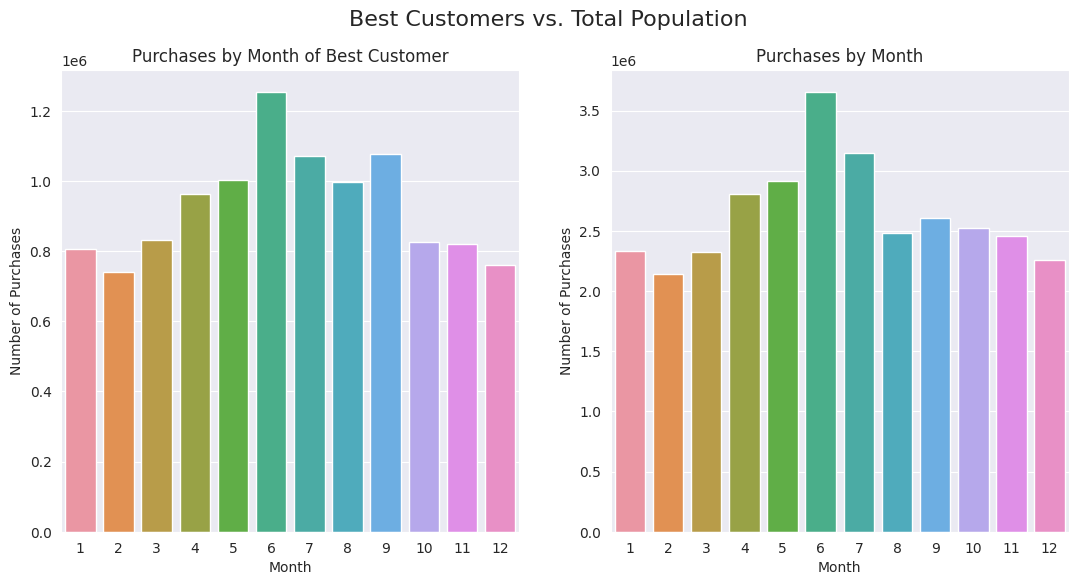

In [65]:
plt.figure(figsize=(13, 6)) 

plt.subplot(1,2,1)
sns.barplot(x=seasonality.index, y=seasonality.values)
plt.title('Purchases by Month of Best Customer')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')

plt.subplot(1,2,2)
sns.barplot(x=seasonality_general.index, y=seasonality_general.values)
plt.title('Purchases by Month')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')

plt.suptitle('Best Customers vs. Total Population', fontsize=16)

plt.show()

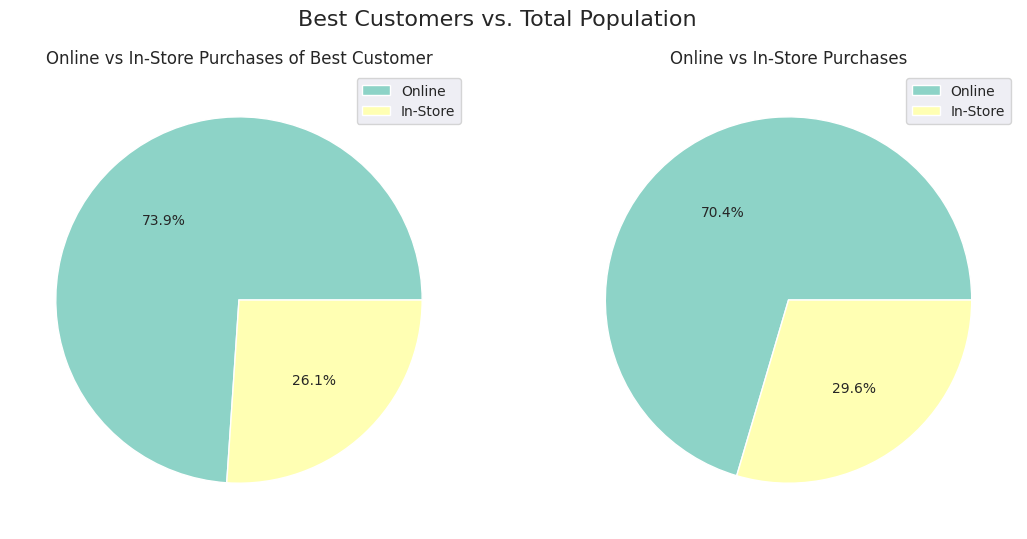

In [66]:
plt.figure(figsize=(13, 6)) 

plt.subplot(1,2,1)
plt.pie(online_vs_instore, autopct='%1.1f%%', colors=sns.color_palette('Set3'))
plt.title('Online vs In-Store Purchases of Best Customer')
plt.legend(['Online', 'In-Store'], loc='upper right') # Add this line to include the legend

plt.subplot(1,2,2)
plt.pie(online_vs_instore_general, autopct='%1.1f%%', colors=sns.color_palette('Set3'))
plt.title('Online vs In-Store Purchases')
plt.legend(['Online', 'In-Store'], loc='upper right')

plt.suptitle('Best Customers vs. Total Population', fontsize=16)

plt.show()

**Compared to the Population insights (from step 1.3 - EDA over transactions), the most valuable customers tend to:**
* Have similar price preferences as the population - Most transactions happen below €50.
* Buy more in September - Both peak at June but this segment also peaks at September.
* Buy more online - In population, 70.4% of purchases happens online but 73.9% within this segment.

## Step 4.3: Are there any variations by age or generation among the most valuable customer segments?

Expectation: Even within this broad segment, there can be significant differences. For instance, younger millennials and Gen Z might be more influenced by social media trends and place a higher value on sustainability. Older millennials, on the other hand, might prioritize quality and versatility.

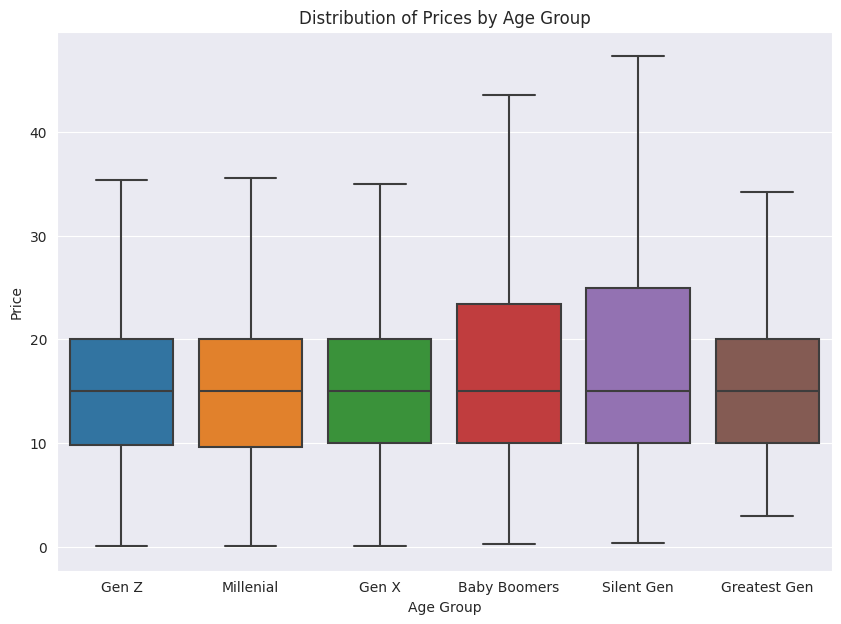

In [67]:
age_group_order = ['Gen Z', 'Millenial', 'Gen X', 'Baby Boomers', 'Silent Gen', 'Greatest Gen']

plt.figure(figsize=(10, 7))
sns.boxplot(data=most_valuable_customer, x='age_group', y='price', order=age_group_order, showfliers=False)
plt.title('Distribution of Prices by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Price')
plt.show()

**Baby Boomers and the Silent Gen are willing to spend more than other age groups. When focusing on our most prominent age groups, the ideal price range is between €10-€20.**

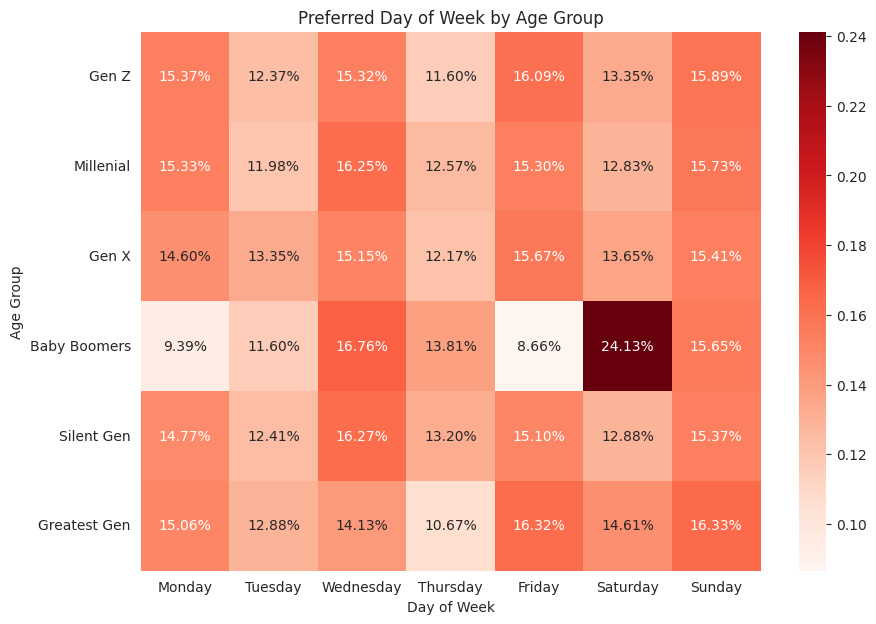

In [68]:
day_week_counts = most_valuable_customer.groupby(['age_group', 'day_of_week']).size().unstack(fill_value=0)
day_week_proportions = day_week_counts.div(day_week_counts.sum(axis=1), axis=0)

plt.figure(figsize=(10, 7))
sns.heatmap(day_week_proportions, annot=True, cmap='Reds', fmt='.2%', cbar=True,
            xticklabels=day_order, yticklabels=age_group_order)
plt.title('Preferred Day of Week by Age Group')
plt.xlabel('Day of Week')
plt.ylabel('Age Group')
plt.yticks(rotation=0)
plt.show()

**All age groups show an increased preference for activity on weekends, with Sunday often being a common day of increased activity. This indicates that weekends are important for engagement across generations. Millennials uniquely show a peak on Wednesday, indicating that midweek promotions or events might be particularly effective with this age group. The peak on Saturday for Baby Boomers suggests this day could be the most effective for targeting this group with special offers or events. Messaging and marketing materials can be tailored to the preferred days, ensuring that communication is timed for maximum impact.**

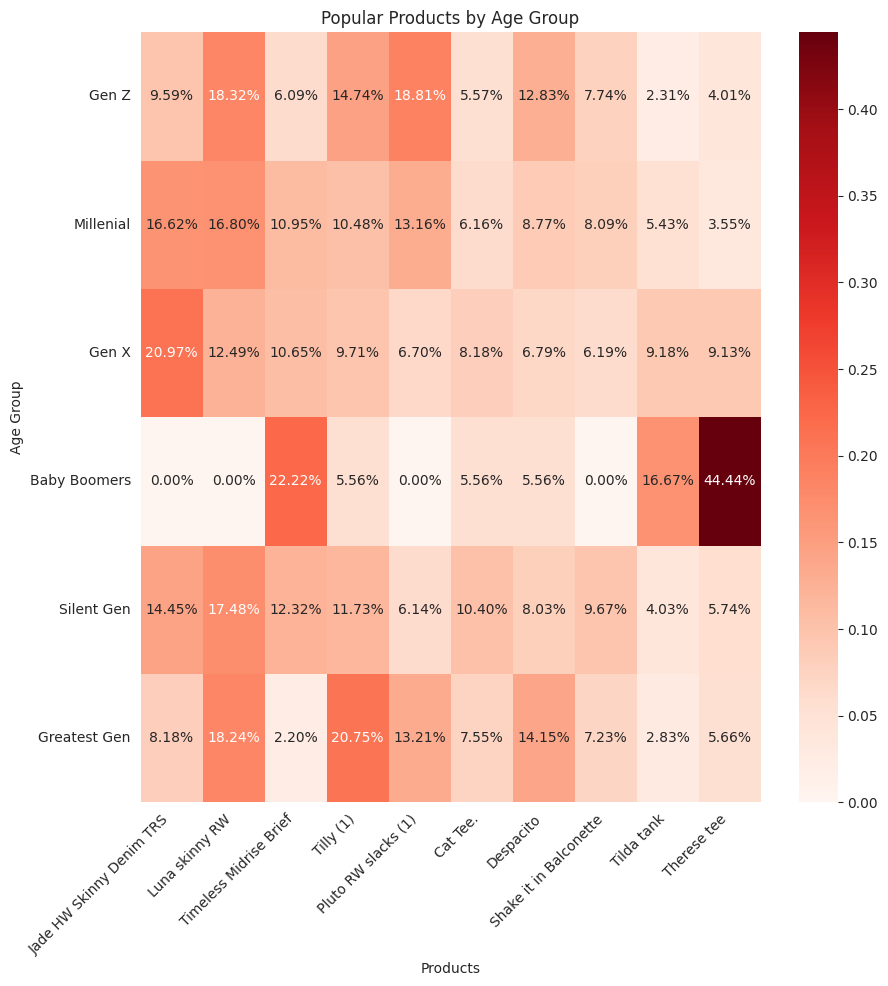

In [69]:
top_n = 10
product_counts = most_valuable_customer['prod_name'].value_counts()
top_n_products = product_counts.head(top_n)
top_n_product_names = top_n_products.index.tolist()

product_age_counts = most_valuable_customer.groupby(['age_group', 'prod_name']).size().unstack(fill_value=0)
product_age_counts = product_age_counts[top_n_product_names]
product_age_proportions = product_age_counts.div(product_age_counts.sum(axis=1), axis=0)

plt.figure(figsize=(10, 10))
sns.heatmap(product_age_proportions, annot=True, cmap='Reds', fmt='.2%', cbar=True,
            xticklabels=top_n_product_names, yticklabels=age_group_order)
plt.title('Popular Products by Age Group')
plt.xlabel('Products')
plt.ylabel('Age Group')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**"Jade HW Skinny Denim TRS" and "Luna skinny RW" have a cross-generational appeal, with noticeable interest from Gen Z to Silent Gen. Products like "Theresa tee" and "Timeless Midrise Brief" for Baby Boomers may represent niche markets that are particularly important to this age group.**

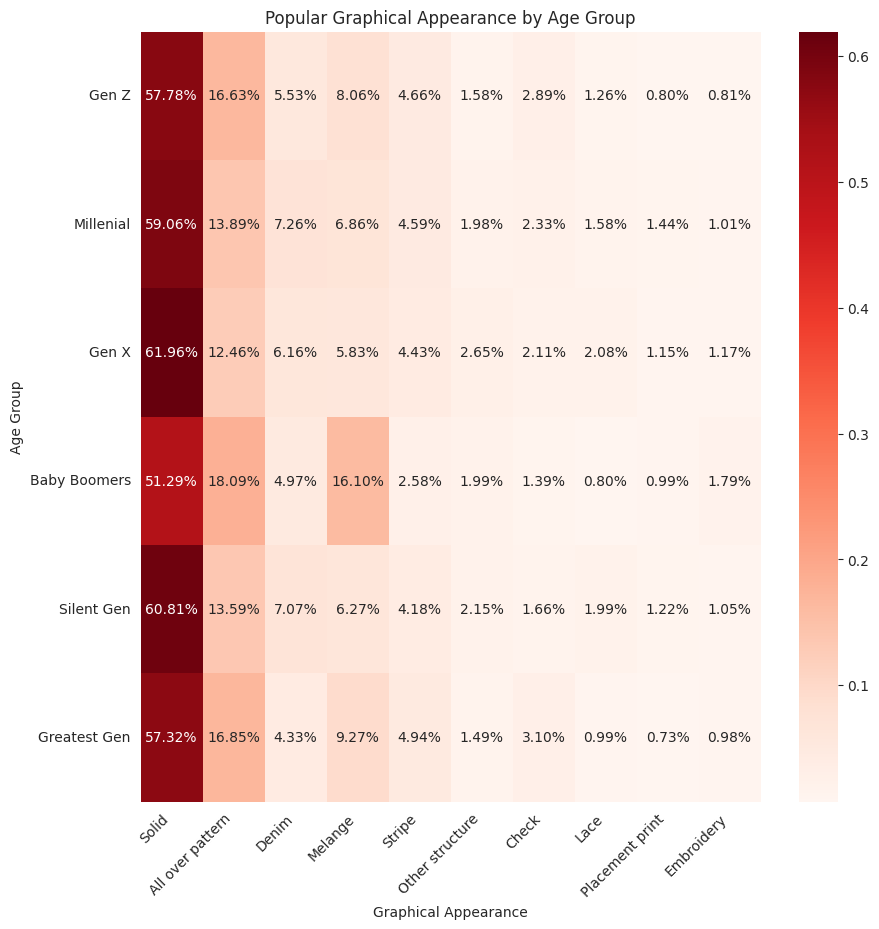

In [70]:
graph_counts = most_valuable_customer['graphical_appearance_name'].value_counts()
top_n_graph = graph_counts.head(top_n)
top_n_graph_names = top_n_graph.index.tolist()

graph_age_counts = most_valuable_customer.groupby(['age_group', 'graphical_appearance_name']).size().unstack(fill_value=0)
graph_age_counts = graph_age_counts[top_n_graph_names]
graph_age_proportions = graph_age_counts.div(graph_age_counts.sum(axis=1), axis=0)

plt.figure(figsize=(10, 10))
sns.heatmap(graph_age_proportions, annot=True, cmap='Reds', fmt='.2%', cbar=True,
            xticklabels=top_n_graph_names, yticklabels=age_group_order)
plt.title('Popular Graphical Appearance by Age Group')
plt.xlabel('Graphical Appearance')
plt.ylabel('Age Group')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**Since 'Solid' is universally popular, it should be a core element of the product offerings. Marketing can emphasize the versatility and timeless nature of solid colors. Given their broad appeal, especially to younger demographics, 'All Over Pattern' designs can be highlighted in products aimed at a wider age range.**

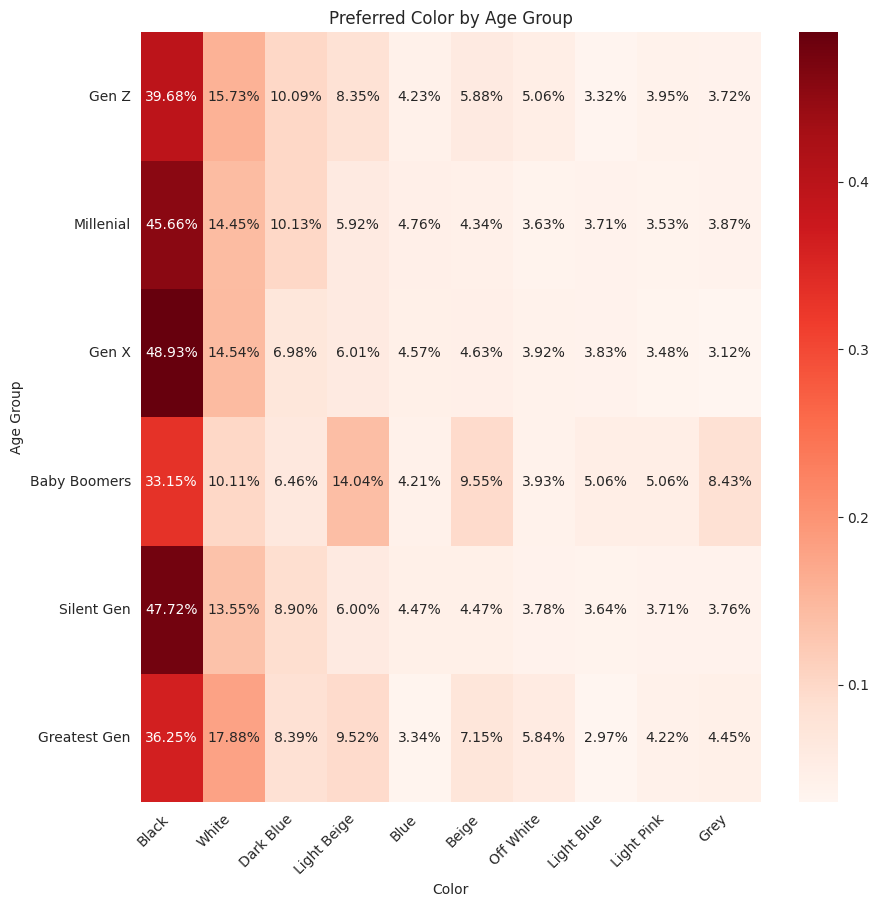

In [71]:
color_counts = most_valuable_customer['colour_group_name'].value_counts()
top_n_colors = color_counts.head(top_n)
top_n_color_names = top_n_colors.index.tolist()

color_age_counts = most_valuable_customer.groupby(['age_group', 'colour_group_name']).size().unstack(fill_value=0)
color_age_counts = color_age_counts[top_n_color_names]
color_age_proportions = color_age_counts.div(color_age_counts.sum(axis=1), axis=0)

plt.figure(figsize=(10, 10))
sns.heatmap(color_age_proportions, annot=True, cmap='Reds', fmt='.2%', cbar=True,
            xticklabels=top_n_color_names, yticklabels=age_group_order)
plt.title('Preferred Color by Age Group')
plt.xlabel('Color')
plt.ylabel('Age Group')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**Given their widespread appeal, 'Black' and 'White' could be considered 'safe' choices for products intended to attract a broad audience. For more targeted campaigns or seasonal collections, incorporate Dark Blue and Light Beige to cater to specific tastes while still maintaining broad relevance.**

# Step 5: Conclusion
Expected outcome: Viable marketing strategy for H&M

* How can behavior segmentation inform targeted promotions and loyalty programs?
* What incentives or rewards can be offered to further engage and retain loyal customers?
* How can RFM segments be used to prioritize marketing efforts and customer engagement strategies?
* How could the findings help H&M better boost sales for the most valuable customer segment? 

Based on the research questions you've outlined, we can form a hypothetical marketing strategy for H&M. 

**Here are part of the insights we derived from Step 4:**
1. The most valuable customers exhibit a strong preference for the Women's Tailoring section, opting for tailored, semi-formal attire that underscores their need for quality and fit—likely driven by their professional or social engagements. These customers predominantly choose solid-colored blouses, especially in versatile shades like white and black, indicating a preference for classic, adaptable pieces.
1. The most valuable customers tend to make purchases online and in June or September. Individual in this segment exhibits similar price preferences to the overall population. The majority of transactions, for both the general population and the most valuable segment, fall below the €50 mark.
3. Behavior segmentation reveals that targeting Baby Boomers and Silent Gen on Saturdays and Millennials on Wednesdays with promotions and events within the €10-€20 range can boost engagement and loyalty. Tailored loyalty programs offering incentives like exclusive early access to new 'Solid' color lines, such as the universally popular 'Jade HW Skinny Denim TRS' and 'Luna skinny RW,' could incentivize repeat purchases. Using RFM analysis, H&M could prioritize high-spending Baby Boomers and Silent Gen for premium rewards, while engaging Millennials with midweek discounts to elevate their lifetime value. Emphasizing weekends for broad-based campaigns, especially in favored black and white apparel, aligns with peak activity times across demographics, thereby maximizing sales potential for H&M's valuable customer segments.

**Given these insights, a viable marketing strategy could include the following elements:**

1. Product Focus: 
    * Targeted Emails and Social Media Ads: Send personalized emails and ads featuring new arrivals and exclusive previews especially in the Womens Tailoring section. Highlight new blouses and tailored pieces in classic colors.
    * Collaborations with Designers: Launch capsule collections in collaboration with renowned designers to create exclusive, high-quality tailored garments that attract fashion-conscious consumers.
    * Eco-Friendly Lines: Introduce an eco-friendly line within the Womens Tailoring section to appeal to environmentally conscious consumers, emphasizing sustainable materials and ethical manufacturing processes.
    * Transparency Campaigns: Run campaigns that detail the craftsmanship, material quality, and ethical efforts behind the creation of garments in the Womens Tailoring section, building trust and enhancing brand value.
2. Seasonal Promotions:
    * Given the purchasing behavior of the most valuable customers, H&M could launch promotional campaigns mainly in June or September. This could involve exclusive offers, special discounts, early access to new collections, or other incentives to encourage purchases.
    * Schedule targeted promotions for Baby Boomers and Silent Gen on Saturdays and for Millennials on Wednesdays to boost engagement and capitalize on customer availability.
3. Pricing strategy:
    * The majority of transactions, for both the general population and the most valuable segment, fall below the €50 mark. This indicates that while these customers may spend more overall due to their higher value, they still tend to make purchases within a similar price range as the broader customer base. This insight suggests that strategies aimed at this segment should focus not only on attracting larger transactions but also on catering to their preferences for products or services within a certain price range.
    * Introduce special promotions in the €10-€20 range.
4. Personalized Marketing:
    * Align broad-based marketing campaigns to the weekends to capitalize on the general peak activity times.
    * Implement midweek targeted discounts to draw in Millennials, possibly through social media channels and email marketing.
    * Synchronize in-store promotions with online campaigns to create a seamless customer experience.
    * Utilize social media platforms to drive online and in-store traffic, particularly leveraging influencer partnerships to showcase the tailoring section.
5. Loyalty Program:
    * Develop a loyalty program with tiered rewards, giving high-spending Baby Boomers and Silent Gen premium rewards like exclusive early access to new collections.
    * Provide early access to popular items to loyal customers as a part of the loyalty program.